In [1]:
import multirex as mrex
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import pandas as pd
from tqdm import tqdm
import os
import re
import gc

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.exceptions import DataConversionWarning
import warnings

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
## general metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# accuracy, f1 , recall, precision
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
## hamming loss and exact match
from sklearn.metrics import hamming_loss, accuracy_score

#%matplotlib inline

def remove_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings(action='ignore', category=DataConversionWarning)

#load txt waves.txt
waves=np.loadtxt("waves.txt")
n_points = len(waves)
indices = np.linspace(0, len(waves) - 1, n_points, endpoint=True)
indices = np.round(indices).astype(int)  # Redondear los índices y convertir a entero

# Seleccionar los elementos de la lista usando los índices
puntos_seleccionados = waves[indices]
waves=puntos_seleccionados
wn_grid=np.sort((10000/waves))

Loading MultiREx version 0.2.3


In [2]:
def apply_contaminations_from_files(
    contamination_files, df, n_points,
):
    """
    Aplica múltiples contaminaciones a los datos desde una lista de archivos de contaminación
    y devuelve un DataFrame con todas las combinaciones, incluyendo el caso sin contaminación.

    Parámetros:
        contamination_files (list de str): Lista de rutas a archivos .txt con contaminaciones.
        df (pandas.DataFrame): DataFrame original sobre el cual se aplicarán las contaminaciones.
        n_points (int): Número de columnas a las que se aplicará la contaminación.

    Retorna:
        pandas.DataFrame: DataFrame con todas las combinaciones de contaminaciones,
                          incluyendo sin contaminación, y con columnas adicionales 'f_spot' y 'f_fac'.
    """
    # Lista para almacenar los DataFrames resultantes
    df_list = []

    # Caso sin contaminación
    df_no_contam = df.copy()
    df_no_contam['f_spot'] = 0.0
    df_no_contam['f_fac'] = 0.0
    # Reordenar columnas para que 'f_spot' y 'f_fac' estén al inicio
    cols = ['f_spot', 'f_fac'] + [
        col for col in df_no_contam.columns if col not in ['f_spot', 'f_fac']
    ]
    df_no_contam = df_no_contam[cols]
    df_list.append(df_no_contam)

    # Expresión regular para extraer f_spot y f_fac del nombre del archivo
    pattern = r"fspot(?P<f_spot>[0-9.]+)_ffac(?P<f_fac>[0-9.]+)\.txt$"

    for file_path in contamination_files:
        # Verificar que el archivo exista
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"El archivo {file_path} no existe.")

        # Extraer f_spot y f_fac del nombre del archivo
        filename = os.path.basename(file_path)
        match = re.search(pattern, filename)
        if not match:
            raise ValueError(
                f"El nombre del archivo '{filename}' no coincide con el patrón esperado."
            )

        f_spot = float(match.group('f_spot'))
        f_fac = float(match.group('f_fac'))

        # Leer los valores de contaminación desde el archivo txt
        try:
            # Cargar los datos asegurando que siempre haya al menos dos dimensiones
            contamination_data = np.loadtxt(file_path, ndmin=2)
            # Si la contaminación tiene al menos dos columnas, tomar la segunda
            if contamination_data.shape[1] >= 2:
                contam_values = contamination_data[:, 1]
            else:
                contam_values = contamination_data.flatten()

            # Verificar que la longitud de contam_values coincide con n_points
            if len(contam_values) != n_points:
                raise ValueError(
                    f"El número de valores de contaminación en '{filename}' ({len(contam_values)}) "
                    f"no coincide con n_points ({n_points})."
                )
        except Exception as e:
            raise ValueError(f"Error al leer el archivo {file_path}: {e}")
        contam_values = contam_values[::-1]
        # Crear una copia del DataFrame original
        df_contam = df.copy()

        # Aplicar la contaminación multiplicando las últimas n_points columnas por contam_values
        data_columns = df_contam.columns[-n_points:]
        # Multiplicar las columnas por contam_values (aplicación columnar)
        df_contam[data_columns] = df_contam[data_columns].multiply(contam_values, axis=1)

        # Añadir columnas 'f_spot' y 'f_fac'
        df_contam['f_spot'] = f_spot
        df_contam['f_fac'] = f_fac

        # Reordenar columnas para que 'f_spot' y 'f_fac' estén al inicio
        cols = ['f_spot', 'f_fac'] + [
            col for col in df_contam.columns if col not in ['f_spot', 'f_fac']
        ]
        df_contam = df_contam[cols]

        # Añadir el DataFrame contaminado a la lista
        df_list.append(df_contam)

    # Concatenar todos los DataFrames en uno solo
    df_final = pd.concat(df_list, ignore_index=True)

    # Definir atributos .data y .params en el DataFrame final
    df_final.data = df_final.iloc[:, -n_points:]
    df_final.params = df_final.iloc[:, :-n_points]

    return df_final

## load data

In [3]:
import pandas as pd

contamination_files = [
    'stellar_contamination/TRAPPIST-1_contam_fspot0.01_ffac0.08.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.01_ffac0.54.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.01_ffac0.70.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.08_ffac0.08.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.08_ffac0.54.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.08_ffac0.70.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.26_ffac0.08.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.26_ffac0.54.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.26_ffac0.70.txt'
]

def filtrar_filas(df):
    """
    Filtra las filas de un DataFrame donde al menos una de las columnas
    "atm CH4", "atm O3" o "atm H2O" tenga un valor mayor o igual a -8.

    Si ninguna de estas columnas está presente, devuelve el DataFrame sin cambios.
    """
    columnas_a_filtrar = ["atm CH4", "atm O3", "atm H2O"]
    columnas_presentes = [col for col in columnas_a_filtrar if col in df.columns]

    for chem in columnas_presentes:

        df = df[df[chem]>=-8]

        # Definir atributos .data y .params en el DataFrame final
        df.data = df.iloc[:, -n_points:]
        df.params = df.iloc[:, :-n_points]

    return df

# Procesamiento de los diferentes datasets

try:
    airless_data = pd.read_csv("spec_data/airless_data.csv")
    airless_data = apply_contaminations_from_files(contamination_files, airless_data, n_points)
except Exception as e:
    print(f"Error al procesar airless_data: {e}")

try:
    CO2_data = pd.read_csv("spec_data/CO2_data.csv")
    CO2_data = apply_contaminations_from_files(contamination_files, CO2_data, n_points)
except Exception as e:
    print(f"Error al procesar CO2_data: {e}")

try:
    CH4_data = pd.read_csv("spec_data/CH4_data.csv")
    CH4_data = filtrar_filas(CH4_data)  # Aplicar el filtrado
    CH4_data = apply_contaminations_from_files(contamination_files, CH4_data, n_points)

except Exception as e:
    print(f"Error al procesar CH4_data: {e}")

try:
    O3_data = pd.read_csv("spec_data/O3_data.csv")
    O3_data = filtrar_filas(O3_data)  # Aplicar el filtrado
    O3_data = apply_contaminations_from_files(contamination_files, O3_data, n_points)

except Exception as e:
    print(f"Error al procesar O3_data: {e}")

try:
    H2O_data = pd.read_csv("spec_data/H2O_data.csv")
    H2O_data = filtrar_filas(H2O_data)  # Aplicar el filtrado
    H2O_data = apply_contaminations_from_files(contamination_files, H2O_data, n_points)

except Exception as e:
    print(f"Error al procesar H2O_data: {e}")

try:
    CH4_O3_data = pd.read_csv("spec_data/CH4_O3_data.csv")
    CH4_O3_data = filtrar_filas(CH4_O3_data)  # Aplicar el filtrado
    CH4_O3_data = apply_contaminations_from_files(contamination_files, CH4_O3_data, n_points)

except Exception as e:
    print(f"Error al procesar CH4_O3_data: {e}")

try:
    CH4_H2O_data = pd.read_csv("spec_data/CH4_H2O_data.csv")
    CH4_H2O_data = filtrar_filas(CH4_H2O_data)  # Aplicar el filtrado
    CH4_H2O_data = apply_contaminations_from_files(contamination_files, CH4_H2O_data, n_points)

except Exception as e:
    print(f"Error al procesar CH4_H2O_data: {e}")

try:
    O3_H2O_data = pd.read_csv("spec_data/O3_H2O_data.csv")
    O3_H2O_data = filtrar_filas(O3_H2O_data)  # Aplicar el filtrado
    O3_H2O_data = apply_contaminations_from_files(contamination_files, O3_H2O_data, n_points)

except Exception as e:
    print(f"Error al procesar O3_H2O_data: {e}")

try:
    CH4_O3_H2O_data = pd.read_csv("spec_data/CH4_O3_H2O_data.csv")
    CH4_O3_H2O_data = filtrar_filas(CH4_O3_H2O_data)  # Aplicar el filtrado
    CH4_O3_H2O_data = apply_contaminations_from_files(contamination_files, CH4_O3_H2O_data, n_points)

except Exception as e:
    print(f"Error al procesar CH4_O3_H2O_data: {e}")


C:\Users\User\AppData\Local\Temp\ipykernel_28156\951796714.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_contam['f_spot'] = f_spot
C:\Users\User\AppData\Local\Temp\ipykernel_28156\951796714.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_contam['f_fac'] = f_fac
C:\Users\User\AppData\Local\Temp\ipykernel_28156\951796714.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usin

In [4]:
# Función para normalizar por filas con Min-Max, con manejo de casos especiales
def normalize_min_max_by_row(df):
    min_by_row = df.min(axis=1)
    max_by_row = df.max(axis=1)
    # Diferencia entre máximos y mínimos
    range_by_row = max_by_row - min_by_row
    # Evitar división por cero asignando NaN, que luego reemplazaremos
    normalized = (df.sub(min_by_row, axis=0)).div(range_by_row, axis=0)
    # Manejar filas donde max == min (rango es cero), puedes ajustar este valor
    normalized[range_by_row == 0] = 0  # O cualquier otro valor que consideres apropiado
    return normalized

import ast
# Función para convertir string a lista
def string_to_list(string):
    return ast.literal_eval(string)

def plot_confusion_matrix(y_test, y_pred, labels, display_labels, title):
    """
    Función para calcular y mostrar la matriz de confusión con etiquetas descriptivas y un título personalizado.

    Parámetros:
    - y_test: Array con los valores reales.
    - y_pred: Array con las predicciones del modelo.
    - labels: Lista de las etiquetas de clase en el orden en que deben ser tratadas.
    - display_labels: Lista con los nombres descriptivos para las etiquetas de las clases para visualización.
    - title: String con el título para el gráfico de la matriz de confusión.
    """

    # Calcula la matriz de confusión con las etiquetas descriptivas
    cm = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')

    # Crea el display de la matriz de confusión con etiquetas descriptivas
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(values_format=".0%", colorbar=True, ax=ax)
    disp.im_.colorbar.remove()  # Remueve la barra de color automática para reemplazarla
    disp.im_.set_clim(0, 1)  # Asegura que los límites de la barra de colores sean de 0 a 1

    # Crea manualmente la barra de colores con los límites correctos
    cbar = fig.colorbar(disp.im_, ax=ax)
    cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))  # Corrige el formateador para mostrar en porcentajes

    # Ajustes de formato y título
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    plt.title(title, fontsize=20)

    plt.show()

## Train data

In [5]:
import numpy as np
import pandas as pd
import warnings

def generate_df_with_noise_std(df, n_repeat, noise_std, seed=None):
    """
    Genera un nuevo DataFrame aplicando ruido Gaussiano de desviación estándar especificada
    a los espectros de manera vectorizada y concatena el resultado con otro DataFrame que
    contiene otras columnas de información.

    Parámetros:
    - df: DataFrame con parámetros y espectros. Debe tener atributos 'params' y 'data'.
          Ejemplo: df.params, df.data
    - n_repeat: Número de veces que se replica cada espectro.
    - noise_std: Desviación estándar del ruido a aplicar. Puede ser un número único o una
                 lista/array con una desviación estándar para cada espectro.
    - seed: Semilla para el generador de números aleatorios (opcional).

    Retorna:
    - Nuevo DataFrame con parámetros y espectros con ruido agregado en el mismo formato
      que el DataFrame de entrada. df.params, df.data
    """
    # Verificación de atributos 'params' y 'data' en el DataFrame
    if not hasattr(df, "params"):
        print("Advertencia: No se encontró el atributo 'params' en el DataFrame.")
        df_params = pd.DataFrame()
        if not hasattr(df, "data"):
            print("Advertencia: No se encontró el atributo 'data' en el DataFrame.",
                  "Se considerará que el DataFrame contiene solo datos espectrales.")
            df_spectra = df
    else:
        if not hasattr(df, "data"):
            raise ValueError("El DataFrame debe tener un atributo 'data'.")
        else:
            df_params = df.params
            df_spectra = df.data

    # Validaciones de tipos y valores de los parámetros
    if not isinstance(df_spectra, pd.DataFrame):
        raise ValueError("df_spectra debe ser un pandas DataFrame.")
    if not isinstance(df_params, pd.DataFrame):
        raise ValueError("df_params debe ser un pandas DataFrame.")
    if (not isinstance(n_repeat, int) or n_repeat <= 0):
        raise ValueError("n_repeat debe ser un entero positivo.")
    if isinstance(noise_std, (int, float)):
        if noise_std < 0:
            raise ValueError("noise_std debe ser un número positivo.")
    elif isinstance(noise_std, (list, np.ndarray, pd.Series)):
        if not all(n > 0 for n in noise_std):
            raise ValueError("Todos los valores en noise_std deben ser positivos.")
        if len(noise_std) != len(df_spectra):
            raise ValueError("La longitud de noise_std debe coincidir con el número de espectros en df.")
    else:
        raise ValueError("noise_std debe ser un número positivo o una lista/array de números positivos.")
    if (seed is not None and
        (not isinstance(seed, int) or seed < 0)):
        raise ValueError("seed debe ser un entero no negativo.")

    # Configuración de la semilla para reproducibilidad
    if seed is not None:
        np.random.seed(seed)  

    # Replicación del DataFrame de espectros según el factor de repetición
    df_spectra_replicated = pd.DataFrame(
        np.repeat(df_spectra.values, n_repeat, axis=0),
        columns=df_spectra.columns
    )

    # Manejo de noise_std: si es escalar, se expande; si es array, se replica según n_repeat
    if isinstance(noise_std, (int, float)):
        noise_replicated = np.full(df_spectra_replicated.shape, noise_std)
    else:
        noise_array = np.array(noise_std)
        noise_replicated = np.repeat(noise_array[:, np.newaxis], n_repeat, axis=0)
        noise_replicated = np.tile(noise_replicated, (1, df_spectra_replicated.shape[1]))

    # Aplicación vectorizada del ruido Gaussiano
    gaussian_noise = np.random.normal(0, noise_replicated, df_spectra_replicated.shape)
    df_spectra_replicated += gaussian_noise

    # Replicación del DataFrame de parámetros para que coincida con el número de filas de los espectros replicados
    df_other_columns_replicated = pd.DataFrame(
        np.repeat(df_params.values, n_repeat, axis=0),
        columns=df_params.columns
    )

    # Inserción de la columna 'noise' y 'noise_std' en los parámetros replicados
    if isinstance(noise_std, (int, float)):
        df_other_columns_replicated.insert(0, 'noise_std', noise_std)
    else:
        df_other_columns_replicated.insert(0, 'noise_std', np.repeat(noise_std, n_repeat))
    df_other_columns_replicated.insert(1, 'n_repeat', n_repeat)

    # Concatenación de parámetros y espectros ruidosos
    df_final = pd.concat(
        [df_other_columns_replicated.reset_index(drop=True),
         df_spectra_replicated.reset_index(drop=True)],
        axis=1
    )

    # Asignación de atributos 'data' y 'params' al DataFrame final
    warnings.filterwarnings("ignore")
    df_final.data = df_final.iloc[:, -df_spectra_replicated.shape[1]:]
    df_final.params = df_final.iloc[:, :df_other_columns_replicated.shape[1]]
    warnings.filterwarnings("default")
    
    return df_final


### SNR = 1

In [13]:
noise =  mrex.generate_df_SNR_noise(
    df=CO2_data,
    n_repeat=1,
    SNR=1     
)["noise"][1]
noise =  mrex.generate_df_SNR_noise(
    df=CO2_data,
    n_repeat=1,
    SNR=1     
)["noise"][1]


SNR1_CO2_data = generate_df_with_noise_std(
    df=CO2_data,
    n_repeat=10_000,
    noise_std = noise     
)

SNR1_CH4_data = generate_df_with_noise_std(
    df=CH4_data,
    n_repeat=250,
    noise_std = noise     
)

SNR1_O3_data = generate_df_with_noise_std(
    df=O3_data,
    n_repeat=250,
    noise_std = noise     
)

SNR1_H2O_data = generate_df_with_noise_std(
    df=H2O_data,
    n_repeat=250,
    noise_std = noise     
)

SNR1_CH4_O3_data = generate_df_with_noise_std(
    df=CH4_O3_data,
    n_repeat=30,
    noise_std = noise
)

SNR1_CH4_H2O_data = generate_df_with_noise_std(
    df=CH4_H2O_data,
    n_repeat=30,
    noise_std = noise
)

SNR1_O3_H2O_data = generate_df_with_noise_std(
    df=O3_H2O_data,
    n_repeat=30,
    noise_std = noise
)

SNR1_CH4_O3_H2O_data = generate_df_with_noise_std(
    df=CH4_O3_H2O_data,
    n_repeat=5,
    noise_std = noise
)
    
    
SNR1_airless_data = generate_df_with_noise_std(
    df=airless_data,
    n_repeat=10_000,
    noise_std = noise   
)

SNR1_df = pd.concat(
    [
        SNR1_CO2_data,
        SNR1_CH4_data,
        SNR1_O3_data,
        SNR1_H2O_data,
        SNR1_CH4_O3_data,
        SNR1_CH4_H2O_data,
        SNR1_O3_H2O_data,
        SNR1_CH4_O3_H2O_data,
        SNR1_airless_data
    ],
    ignore_index=True
) 

del (
        SNR1_CO2_data,
        SNR1_CH4_data,
        SNR1_O3_data,
        SNR1_H2O_data,
        SNR1_CH4_O3_data,
        SNR1_CH4_H2O_data,
        SNR1_O3_H2O_data,
        SNR1_CH4_O3_H2O_data,
        SNR1_airless_data
        
)

gc.collect()

0

#### noise plot

In [14]:
high_atm = SNR1_df[
    (SNR1_df["f_spot"] == 0) &
    (SNR1_df["f_fac"] == 0) &
    (SNR1_df["atm O3"] == -2)&
    (SNR1_df["atm H2O"] == 0)&
    (SNR1_df["atm CH4"] == -2)
]

med_atm = SNR1_df[
    (SNR1_df["f_spot"] == 0) &
    (SNR1_df["f_fac"] == 0) &
    (SNR1_df["atm O3"] == -5)&
    (SNR1_df["atm H2O"] == 0)&
    (SNR1_df["atm CH4"] == -5)
]

low_atm = SNR1_df[
    (SNR1_df["f_spot"] == 0) &
    (SNR1_df["f_fac"] == 0) &
    (SNR1_df["atm O3"] == -8)&
    (SNR1_df["atm H2O"] == 0)&
    (SNR1_df["atm CH4"] == -6)
]

### clean data from CH4_O3_data

clean_high_atm = CH4_O3_data[
    (CH4_O3_data["f_spot"] == 0) &
    (CH4_O3_data["f_fac"] == 0) &
    (CH4_O3_data["atm O3"] == -2)&
    (CH4_O3_data["atm CH4"] == -2)
]
clean_med_atm = CH4_O3_data[
    (CH4_O3_data["f_spot"] == 0) &
    (CH4_O3_data["f_fac"] == 0) &
    (CH4_O3_data["atm O3"] == -5)&
    (CH4_O3_data["atm CH4"] == -5)
]
clean_low_atm = CH4_O3_data[
    (CH4_O3_data["f_spot"] == 0) &
    (CH4_O3_data["f_fac"] == 0) &
    (CH4_O3_data["atm O3"] == -8)&
    (CH4_O3_data["atm CH4"] == -6)
]

colors = ["#B7950B", "#B03A2E", "#2874A6"]


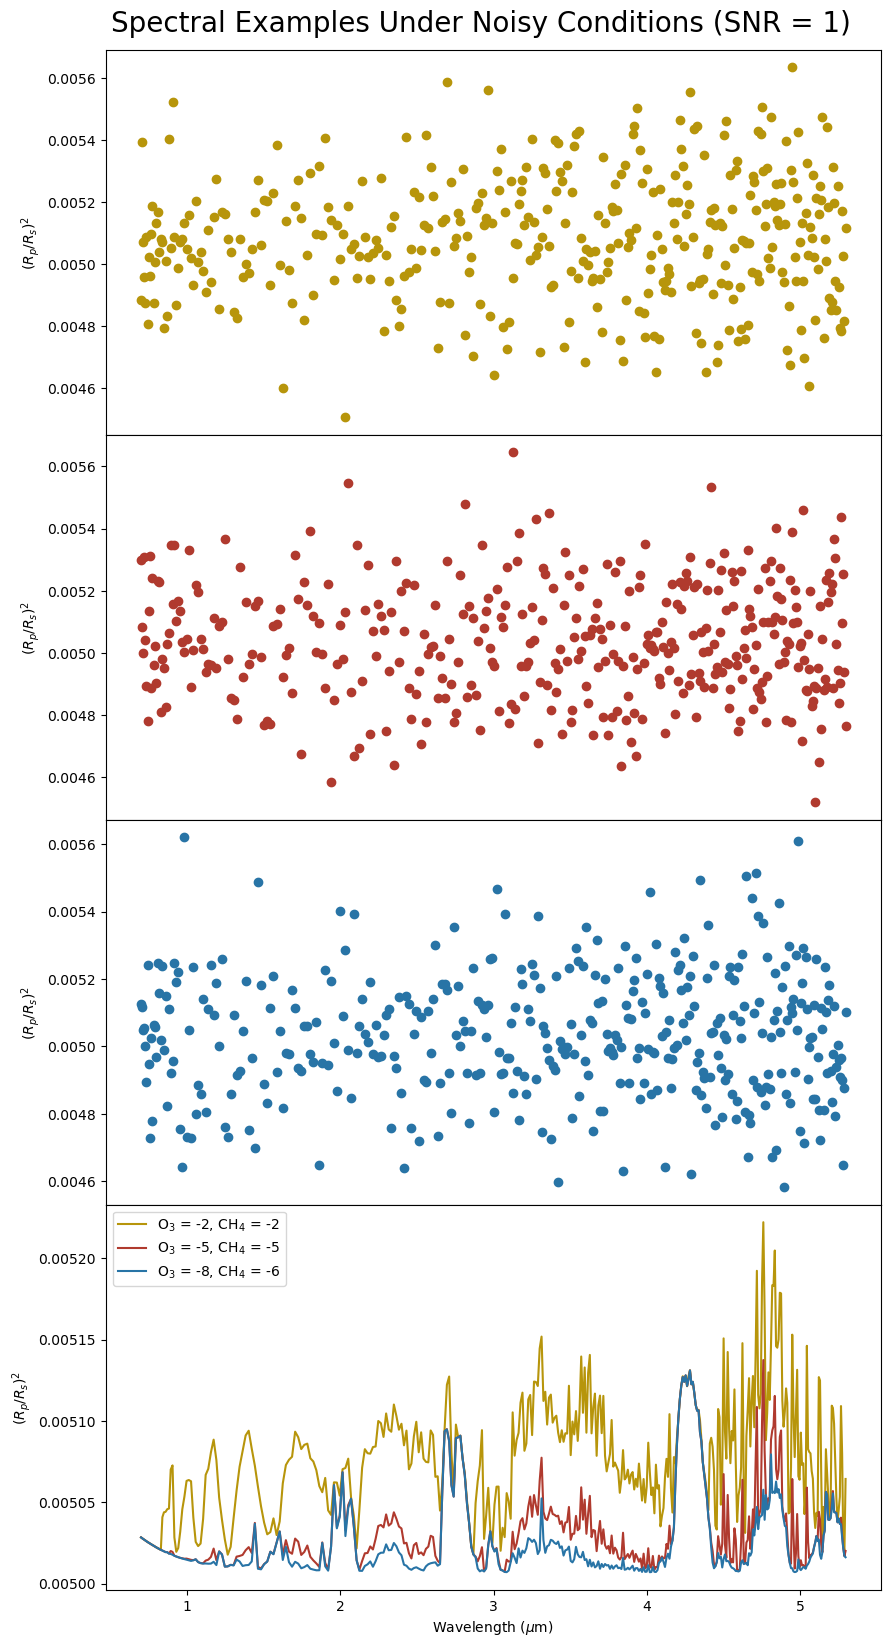

In [15]:
import matplotlib.pyplot as plt

# Crear la figura y los subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 20), sharex=True)

axs[0].scatter(waves[::-1], high_atm.iloc[0, -n_points:],
               label=r"O$_3$ = -2, CH$_4$ = -2",
               color=colors[0])
axs[0].set_ylabel(r"$(R_p/R_s)^2$")
axs[1].scatter(waves[::-1], med_atm.iloc[0, -n_points:],
               label=r"O$_3$ = -5, CH$_4$ = -5",
               color=colors[1])
axs[1].set_ylabel(r"$(R_p/R_s)^2$")
axs[2].scatter(waves[::-1], low_atm.iloc[0, -n_points:], 
               label=r"O$_3$ = -8, CH$_4$ = -6",
               color=colors[2])
axs[2].set_ylabel(r"$(R_p/R_s)^2$")
axs[3].plot(waves[::-1], clean_high_atm.iloc[0, -n_points:],
            label=r"O$_3$ = -2, CH$_4$ = -2",
            color=colors[0])
axs[3].plot(waves[::-1], clean_med_atm.iloc[0, -n_points:],
            label=r"O$_3$ = -5, CH$_4$ = -5",
            color=colors[1])
axs[3].plot(waves[::-1], clean_low_atm.iloc[0, -n_points:], 
            label=r"O$_3$ = -8, CH$_4$ = -6",
            color=colors[2])
axs[3].set_ylabel(r"$(R_p/R_s)^2$")
axs[3].set_xlabel(r"Wavelength ($\mu$m)")

# Posicionar el título general
plt.suptitle("Spectral Examples Under Noisy Conditions (SNR = 1)",
             fontsize=20, y=0.9)

# Ajustar los espacios entre subplots (eliminamos espacio vertical entre ellos)
plt.subplots_adjust(hspace=0)


# Agregar leyenda (en este ejemplo se agregará a la última subplot)
axs[3].legend()

#plt.savefig("fotos/noisy_spectra.svg", format="svg", dpi=300)

plt.show()


### SNR = 3

In [16]:
noise =  mrex.generate_df_SNR_noise(
    df=CO2_data,
    n_repeat=1,
    SNR=3     
)["noise"][1]


SNR3_CO2_data = generate_df_with_noise_std(
    df=CO2_data,
    n_repeat=10_000,
    noise_std = noise     
)

SNR3_CH4_data = generate_df_with_noise_std(
    df=CH4_data,
    n_repeat=250,
    noise_std = noise     
)

SNR3_O3_data = generate_df_with_noise_std(
    df=O3_data,
    n_repeat=250,
    noise_std = noise     
)

SNR3_H2O_data = generate_df_with_noise_std(
    df=H2O_data,
    n_repeat=250,
    noise_std = noise     
)

SNR3_CH4_O3_data = generate_df_with_noise_std(
    df=CH4_O3_data,
    n_repeat=30,
    noise_std = noise
)

SNR3_CH4_H2O_data = generate_df_with_noise_std(
    df=CH4_H2O_data,
    n_repeat=30,
    noise_std = noise
)

SNR3_O3_H2O_data = generate_df_with_noise_std(
    df=O3_H2O_data,
    n_repeat=30,
    noise_std = noise
)

SNR3_CH4_O3_H2O_data = generate_df_with_noise_std(
    df=CH4_O3_H2O_data,
    n_repeat=5,
    noise_std = noise
)
    
SNR3_airless_data = generate_df_with_noise_std(
    df=airless_data,
    n_repeat=10_000,
    noise_std = noise   
)

SNR3_df = pd.concat(
    [
        SNR3_CO2_data,
        SNR3_CH4_data,
        SNR3_O3_data,
        SNR3_H2O_data,
        SNR3_CH4_O3_data,
        SNR3_CH4_H2O_data,
        SNR3_O3_H2O_data,
        SNR3_CH4_O3_H2O_data,
        SNR3_airless_data
    ],
    ignore_index=True
) 


del (
        SNR3_CO2_data,
        SNR3_CH4_data,
        SNR3_O3_data,
        SNR3_H2O_data,
        SNR3_CH4_O3_data,
        SNR3_CH4_H2O_data,
        SNR3_O3_H2O_data,
        SNR3_CH4_O3_H2O_data,
        SNR3_airless_data
)

gc.collect()

1401

### SNR = 6

In [17]:
noise =  mrex.generate_df_SNR_noise(
    df=CO2_data,
    n_repeat=1,
    SNR=6     
)["noise"][1]

SNR6_CO2_data = generate_df_with_noise_std(
    df=CO2_data,
    n_repeat=10_000,
    noise_std = noise     
)

SNR6_CH4_data = generate_df_with_noise_std(
    df=CH4_data,
    n_repeat=100,
    noise_std = noise     
)

SNR6_O3_data = generate_df_with_noise_std(
    df=O3_data,
    n_repeat=100,
    noise_std = noise     
)

SNR6_H2O_data = generate_df_with_noise_std(
    df=H2O_data,
    n_repeat=100,
    noise_std = noise     
)

SNR6_CH4_O3_data = generate_df_with_noise_std(
    df=CH4_O3_data,
    n_repeat=20,
    noise_std = noise
)

SNR6_CH4_H2O_data = generate_df_with_noise_std(
    df=CH4_H2O_data,
    n_repeat=20,
    noise_std = noise
)

SNR6_O3_H2O_data = generate_df_with_noise_std(
    df=O3_H2O_data,
    n_repeat=20,
    noise_std = noise
)

SNR6_CH4_O3_H2O_data = generate_df_with_noise_std(
    df=CH4_O3_H2O_data,
    n_repeat=3,
    noise_std = noise
)
    
SNR6_airless_data = generate_df_with_noise_std(
    df=airless_data,
    n_repeat=10_000,
    noise_std = noise   
)

SNR6_df = pd.concat(
    [
        SNR6_CO2_data,
        SNR6_CH4_data,
        SNR6_O3_data,
        SNR6_H2O_data,
        SNR6_CH4_O3_data,
        SNR6_CH4_H2O_data,
        SNR6_O3_H2O_data,
        SNR6_CH4_O3_H2O_data,
        SNR6_airless_data
    ],
    ignore_index=True
) 


del (
        SNR6_CO2_data,
        SNR6_CH4_data,
        SNR6_O3_data,
        SNR6_H2O_data,
        SNR6_CH4_O3_data,
        SNR6_CH4_H2O_data,
        SNR6_O3_H2O_data,
        SNR6_CH4_O3_H2O_data,
        SNR6_airless_data
        
)

gc.collect()


0

### SNR = 10

In [18]:
noise =  mrex.generate_df_SNR_noise(
    df=CO2_data,
    n_repeat=1,
    SNR=10     
)["noise"][1]

SNR10_CO2_data = generate_df_with_noise_std(
    df=CO2_data,
    n_repeat=10_000,
    noise_std = noise     
)

SNR10_CH4_data = generate_df_with_noise_std(
    df=CH4_data,
    n_repeat=100,
    noise_std = noise    
)

SNR10_O3_data = generate_df_with_noise_std(
    df=O3_data,
    n_repeat=100,
    noise_std = noise    
)

SNR10_H2O_data = generate_df_with_noise_std(
    df=H2O_data,
    n_repeat=100,
    noise_std = noise    
)

SNR10_CH4_O3_data = generate_df_with_noise_std(
    df=CH4_O3_data,
    n_repeat=20,
    noise_std = noise
)

SNR10_CH4_H2O_data = generate_df_with_noise_std(
    df=CH4_H2O_data,
    n_repeat=20,
    noise_std = noise
)

SNR10_O3_H2O_data = generate_df_with_noise_std(
    df=O3_H2O_data,
    n_repeat=20,
    noise_std = noise
)

SNR10_CH4_O3_H2O_data = generate_df_with_noise_std(
    df=CH4_O3_H2O_data,
    n_repeat=3,
    noise_std = noise
)
  
SNR10_airless_data = generate_df_with_noise_std(
    df=airless_data,
    n_repeat=10_000,
    noise_std = noise   
)

SNR10_df = pd.concat(
    [
        SNR10_CO2_data,
        SNR10_CH4_data,
        SNR10_O3_data,
        SNR10_H2O_data,
        SNR10_CH4_O3_data,
        SNR10_CH4_H2O_data,
        SNR10_O3_H2O_data,
        SNR10_CH4_O3_H2O_data,
        SNR10_airless_data
    ],
    ignore_index=True
) 

del (
        SNR10_CO2_data,
        SNR10_CH4_data,
        SNR10_O3_data,
        SNR10_H2O_data,
        SNR10_CH4_O3_data,
        SNR10_CH4_H2O_data,
        SNR10_O3_H2O_data,
        SNR10_CH4_O3_H2O_data,
        SNR10_airless_data
        
)

gc.collect()


0

### SNR = NaN

In [19]:
SNRnan_CO2_data = generate_df_with_noise_std(
    df=CO2_data,
    n_repeat=10_000,
    noise_std = 0     
)

SNRnan_CH4_data = generate_df_with_noise_std(
    df=CH4_data,
    n_repeat=250,
    noise_std = 0     
)

SNRnan_O3_data = generate_df_with_noise_std(
    df=O3_data,
    n_repeat=250,
    noise_std = 0     
)

SNRnan_H2O_data = generate_df_with_noise_std(
    df=H2O_data,
    n_repeat=250,
    noise_std = 0     
)

SNRnan_CH4_O3_data = generate_df_with_noise_std(
    df=CH4_O3_data,
    n_repeat=50,
    noise_std = 0
)

SNRnan_CH4_H2O_data = generate_df_with_noise_std(
    df=CH4_H2O_data,
    n_repeat=50,
    noise_std = 0
)

SNRnan_O3_H2O_data = generate_df_with_noise_std(
    df=O3_H2O_data,
    n_repeat=50,
    noise_std = 0
)

SNRnan_CH4_O3_H2O_data = generate_df_with_noise_std(
    df=CH4_O3_H2O_data,
    n_repeat=5,
    noise_std = 0
)
    
SNRnan_airless_data = generate_df_with_noise_std(
    df=airless_data,
    n_repeat=10_000,
    noise_std = 0
)

SNRnan_df = pd.concat(
    [
        SNRnan_CO2_data,
        SNRnan_CH4_data,
        SNRnan_O3_data,
        SNRnan_H2O_data,
        SNRnan_CH4_O3_data,
        SNRnan_CH4_H2O_data,
        SNRnan_O3_H2O_data,
        SNRnan_CH4_O3_H2O_data
    ],
    ignore_index=True
) 

del (
        SNRnan_CO2_data,
        SNRnan_CH4_data,
        SNRnan_O3_data,
        SNRnan_H2O_data,
        SNRnan_CH4_O3_data,
        SNRnan_CH4_H2O_data,
        SNRnan_O3_H2O_data,
        SNRnan_CH4_O3_H2O_data
        
)

gc.collect()

0

In [20]:
SNRall= pd.concat([SNR1_df,SNR3_df,SNR6_df,SNR10_df,SNRnan_df],
                  ignore_index=True)

SNRall["label"] = SNRall["label"].apply(string_to_list)
SNRall_train, SNRall_test = train_test_split(SNRall, test_size=0.2,)
del SNRall 
gc.collect()

## normalize 

SNRall_train.iloc[:,-n_points:]=normalize_min_max_by_row(SNRall_train.iloc[:,-n_points:])
SNRall_test.iloc[:,-n_points:]=normalize_min_max_by_row(SNRall_test.iloc[:,-n_points:])

SNRall_X_train = SNRall_train.iloc[:,-n_points:]
SNRall_Y_train = np.array(SNRall_train["label"].tolist())

SNRall_X_test = SNRall_test.iloc[:,-n_points:]
SNRall_Y_test = np.array(SNRall_test["label"].tolist())

## RF

In [ ]:
""" from tensorflow import keras 

encoder = keras.models.load_model("AE.keras")

SNRall_X_train = encoder.predict(SNRall_X_train)

SNRall_X_test = encoder.predict(SNRall_X_test) """

<frozen importlib._bootstrap>:488: DeprecationWarning: Type google.protobuf.pyext._message.ScalarMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.
<frozen importlib._bootstrap>:488: DeprecationWarning: Type google.protobuf.pyext._message.MessageMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.


94264/94264 ━━━━━━━━━━━━━━━━━━━━ 912s 10ms/step
23566/23566 ━━━━━━━━━━━━━━━━━━━━ 116s 5ms/step


In [22]:
rf= RandomForestClassifier(n_estimators=100,
                           max_depth= 200,
                           criterion= "entropy",
                           min_samples_leaf= 3,
                           n_jobs=-1,
                           )

rf.fit(SNRall_X_train,SNRall_Y_train)

import joblib
joblib.dump(rf, "MC_rf.joblib")

['MC_rf.joblib']

In [7]:
import joblib
rf = joblib.load("MC_rf.joblib")

from tensorflow import keras 

encoder = keras.models.load_model("AE.keras")

c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Validate per SNR

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from tqdm import tqdm
import pickle
import gc
from sklearn.metrics import (
    f1_score, recall_score, precision_score,
    accuracy_score, hamming_loss, confusion_matrix, classification_report
)
from sklearn.metrics import ConfusionMatrixDisplay

###############################
# Defined Parameters
###############################
SNRS = [1, 2, 3, 4, 5, 7, 10]
f_spot_values = [0, 0.01, 0.08, 0.26]  # Including the base case (0)
f_fac_values = [0, 0.08, 0.54, 0.70]   # Including the base case (0)
mix_ratios = np.logspace(-8, -1, 8)

# Base case
base_f_spot = 0
base_f_fac = 0

def filtrar_data(df, f_spot_val, f_fac_val):
    """Filter DataFrame rows by f_spot and f_fac values."""
    return df[(df["f_spot"] == f_spot_val) & (df["f_fac"] == f_fac_val)]

all_results = {}
factor = 10 / 8
total_combinations = len(f_spot_values) * len(f_fac_values)

with tqdm(total=total_combinations,
          desc="Processing all f_spot and f_fac combinations") as pbar_combos:
    for f_spot_val in f_spot_values:
        for f_fac_val in f_fac_values:
            remove_warnings()
            # Skip combinations where one value is 0 and the other is not (except (0,0))
            if ((f_spot_val == 0 and f_fac_val != 0) or
                (f_spot_val != 0 and f_fac_val == 0)):
                pbar_combos.update(1)
                continue

            mol_SNR_scores = {
                "SNR": [],
                "f1": [[], [], []],
                "recall_score": [[], [], []],
                "precision_score": [[], [], []],
                "accuracy": [[], [], []],
                "min_mix_ratio": [[], [], []],
                "TNR": [[], [], []],
            }

            global_SNR_scores = {
                "SNR": [],
                "f1": [],
                "recall": [],
                "precision": [],
                "perfect_match": [],
                "hamming_loss": [],
                "TNR": [],
                "biosignature_recall": [],
            }

            for SNR in tqdm(SNRS,
                            desc=f"f_spot={f_spot_val}, f_fac={f_fac_val}",
                            leave=False):
                # Generate noise and create noisy data for each molecule
                noise = mrex.generate_df_SNR_noise(
                    df=CO2_data,
                    n_repeat=1,
                    SNR=SNR
                )["noise"][1]

                SNR_test_CO2_data = generate_df_with_noise_std(
                    df=CO2_data,
                    n_repeat=int(2500),
                    noise_std=noise
                )
                SNR_test_CH4_data = generate_df_with_noise_std(
                    df=CH4_data,
                    n_repeat=int(250 * factor),
                    noise_std=noise
                )
                SNR_test_O3_data = generate_df_with_noise_std(
                    df=O3_data,
                    n_repeat=int(250 * factor),
                    noise_std=noise
                )
                SNR_test_H2O_data = generate_df_with_noise_std(
                    df=H2O_data,
                    n_repeat=int(250 * factor),
                    noise_std=noise
                )
                SNR_test_CH4_O3_data = generate_df_with_noise_std(
                    df=CH4_O3_data,
                    n_repeat=int(25 * factor * factor),
                    noise_std=noise
                )
                SNR_test_CH4_H2O_data = generate_df_with_noise_std(
                    df=CH4_H2O_data,
                    n_repeat=int(25 * factor * factor),
                    noise_std=noise
                )
                SNR_test_O3_H2O_data = generate_df_with_noise_std(
                    df=O3_H2O_data,
                    n_repeat=int(25 * factor * factor),
                    noise_std=noise
                )
                SNR_test_CH4_O3_H2O_data = generate_df_with_noise_std(
                    df=CH4_O3_H2O_data,
                    n_repeat=int(5 * factor * factor * factor),
                    noise_std=noise
                )
                SNR_test_airless_data = generate_df_with_noise_std(
                    df=airless_data,
                    n_repeat=2_500 * 3,
                    noise_std=noise
                )

                # Concatenate all generated DataFrames
                SNR_test_df = pd.concat([
                    SNR_test_CO2_data,
                    SNR_test_CH4_data,
                    SNR_test_O3_data,
                    SNR_test_H2O_data,
                    SNR_test_CH4_O3_data,
                    SNR_test_CH4_H2O_data,
                    SNR_test_O3_H2O_data,
                    SNR_test_CH4_O3_H2O_data,
                    SNR_test_airless_data
                ], ignore_index=True)

                # Clean up memory
                del (SNR_test_CO2_data, SNR_test_CH4_data,
                     SNR_test_O3_data, SNR_test_H2O_data,
                     SNR_test_CH4_O3_data, SNR_test_CH4_H2O_data,
                     SNR_test_O3_H2O_data, SNR_test_CH4_O3_H2O_data,
                     SNR_test_airless_data)
                gc.collect()

                # Filter DataFrame by current f_spot and f_fac values
                SNR_test_df = filtrar_data(SNR_test_df, f_spot_val, f_fac_val)
                if SNR_test_df.empty:
                    continue

                # Prepare data for the model
                SNR_test_df["label"] = SNR_test_df["label"].apply(string_to_list)
                SNR_test_df.iloc[:, -n_points:] = normalize_min_max_by_row(
                    SNR_test_df.iloc[:, -n_points:]
                )
                SNR_X_test = SNR_test_df.iloc[:, -n_points:]
                SNR_X_test = encoder.predict(SNR_X_test)

                # Extract true labels
                SNR_test_CH4 = np.array([item[0] for item in SNR_test_df["label"]])
                SNR_test_O3 = np.array([item[1] for item in SNR_test_df["label"]])
                SNR_test_H2O = np.array([item[2] for item in SNR_test_df["label"]])

                SNR_test_df["CH4 label"] = SNR_test_CH4
                SNR_test_df["O3 label"] = SNR_test_O3
                SNR_test_df["H2O label"] = SNR_test_H2O

                # Get predictions and probabilities
                CH4_probabilities = rf.predict_proba(SNR_X_test)[0][:, 1]
                O3_probabilities = rf.predict_proba(SNR_X_test)[1][:, 1]
                H2O_probabilities = rf.predict_proba(SNR_X_test)[2][:, 1]

                CH4_threshold = 0.28
                O3_threshold = 0.24
                H2O_threshold = 0.36

                CH4_y_pred = (CH4_probabilities > CH4_threshold).astype(int)
                O3_y_pred = (O3_probabilities > O3_threshold).astype(int)
                H2O_y_pred = (H2O_probabilities > H2O_threshold).astype(int)

                SNR_test_df["CH4 pred"] = CH4_y_pred
                SNR_test_df["CH4 score"] = CH4_probabilities
                SNR_test_df["O3 pred"] = O3_y_pred
                SNR_test_df["O3 score"] = O3_probabilities
                SNR_test_df["H2O pred"] = H2O_y_pred
                SNR_test_df["H2O score"] = H2O_probabilities

                # Calculate global metrics
                global_SNR_scores["SNR"].append(SNR)
                global_SNR_scores["f1"].append(
                    f1_score(
                        SNR_test_df[["CH4 label", "O3 label", "H2O label"]],
                        SNR_test_df[["CH4 pred", "O3 pred", "H2O pred"]],
                        average="macro"
                    )
                )
                global_SNR_scores["recall"].append(
                    recall_score(
                        SNR_test_df[["CH4 label", "O3 label", "H2O label"]],
                        SNR_test_df[["CH4 pred", "O3 pred", "H2O pred"]],
                        average="macro"
                    )
                )
                global_SNR_scores["precision"].append(
                    precision_score(
                        SNR_test_df[["CH4 label", "O3 label", "H2O label"]],
                        SNR_test_df[["CH4 pred", "O3 pred", "H2O pred"]],
                        average="macro"
                    )
                )
                global_SNR_scores["perfect_match"].append(
                    accuracy_score(
                        SNR_test_df[["CH4 label", "O3 label", "H2O label"]],
                        SNR_test_df[["CH4 pred", "O3 pred", "H2O pred"]]
                    )
                )
                global_SNR_scores["hamming_loss"].append(
                    hamming_loss(
                        SNR_test_df[["CH4 label", "O3 label", "H2O label"]],
                        SNR_test_df[["CH4 pred", "O3 pred", "H2O pred"]]
                    )
                )

                # Calculate biosignature recall for CH4 and O3
                both_CH4_O3_label = ((SNR_test_df["CH4 label"] == 1) &
                                     (SNR_test_df["O3 label"] == 1)).astype(int)
                both_CH4_O3_pred = ((SNR_test_df["CH4 pred"] == 1) &
                                    (SNR_test_df["O3 pred"] == 1)).astype(int)
                biosig_rec = recall_score(both_CH4_O3_label, both_CH4_O3_pred)
                global_SNR_scores["biosignature_recall"].append(biosig_rec)

                # Calculate molecule-specific metrics
                mol_SNR_scores["SNR"].append(SNR)
                for idx, molecule in enumerate(["CH4", "O3", "H2O"]):
                    mol_SNR_scores["f1"][idx].append(
                        f1_score(SNR_test_df[f"{molecule} label"],
                                 SNR_test_df[f"{molecule} pred"])
                    )
                    mol_SNR_scores["recall_score"][idx].append(
                        recall_score(SNR_test_df[f"{molecule} label"],
                                     SNR_test_df[f"{molecule} pred"])
                    )
                    mol_SNR_scores["precision_score"][idx].append(
                        precision_score(SNR_test_df[f"{molecule} label"],
                                        SNR_test_df[f"{molecule} pred"])
                    )
                    mol_SNR_scores["accuracy"][idx].append(
                        accuracy_score(SNR_test_df[f"{molecule} label"],
                                       SNR_test_df[f"{molecule} pred"])
                    )
                    mol_SNR_scores["TNR"][idx].append(
                        recall_score(SNR_test_df[f"{molecule} label"],
                                     SNR_test_df[f"{molecule} pred"],
                                     pos_label=0)
                    )

                # Global TNR is the average of TNRs from all molecules
                global_SNR_scores["TNR"].append(
                    (mol_SNR_scores["TNR"][0][-1] +
                     mol_SNR_scores["TNR"][1][-1] +
                     mol_SNR_scores["TNR"][2][-1]) / 3
                )

                # Calculate min_mix_ratio based on recall threshold (> 0.6)
                CH4_SNR_test_by_atmCH4 = []
                O3_SNR_test_by_atmO3 = []
                H2O_SNR_test_by_atmH2O = []
                for i, j in enumerate(range(-8, 0)):
                    CH4_group = SNR_test_df[SNR_test_df["atm CH4"] == j]
                    co2 = int(len(SNR_test_df[SNR_test_df["CH4 label"] == 0]) / 8)
                    no_CH4 = SNR_test_df[SNR_test_df["CH4 label"] == 0].sample(co2)
                    CH4_SNR_test_by_atmCH4.append(pd.concat([CH4_group, no_CH4]))

                    O3_group = SNR_test_df[SNR_test_df["atm O3"] == j]
                    co2 = int(len(SNR_test_df[SNR_test_df["O3 label"] == 0]) / 8)
                    no_O3 = SNR_test_df[SNR_test_df["O3 label"] == 0].sample(co2)
                    O3_SNR_test_by_atmO3.append(pd.concat([O3_group, no_O3]))

                    H2O_group = SNR_test_df[SNR_test_df["atm H2O"] == j]
                    co2 = int(len(SNR_test_df[SNR_test_df["H2O label"] == 0]) / 8)
                    no_H2O = SNR_test_df[SNR_test_df["H2O label"] == 0].sample(co2)
                    H2O_SNR_test_by_atmH2O.append(pd.concat([H2O_group, no_H2O]))

                CH4_SNR_recall = np.zeros(len(mix_ratios))
                O3_SNR_recall = np.zeros(len(mix_ratios))
                H2O_SNR_recall = np.zeros(len(mix_ratios))
                for m_idx in range(len(mix_ratios)):
                    CH4_labels = CH4_SNR_test_by_atmCH4[m_idx]["CH4 label"].astype(int)
                    CH4_preds = CH4_SNR_test_by_atmCH4[m_idx]["CH4 pred"].astype(int)
                    CH4_SNR_recall[m_idx] = recall_score(CH4_labels, CH4_preds)

                    O3_labels = O3_SNR_test_by_atmO3[m_idx]["O3 label"].astype(int)
                    O3_preds = O3_SNR_test_by_atmO3[m_idx]["O3 pred"].astype(int)
                    O3_SNR_recall[m_idx] = recall_score(O3_labels, O3_preds)

                    H2O_labels = H2O_SNR_test_by_atmH2O[m_idx]["H2O label"].astype(int)
                    H2O_preds = H2O_SNR_test_by_atmH2O[m_idx]["H2O pred"].astype(int)
                    H2O_SNR_recall[m_idx] = recall_score(H2O_labels, H2O_preds)

                CH4_min_mix_ratio = mix_ratios[np.where(CH4_SNR_recall >= 0.6)][0] if np.any(CH4_SNR_recall >= 0.6) else 1
                O3_min_mix_ratio = mix_ratios[np.where(O3_SNR_recall >= 0.6)][0] if np.any(O3_SNR_recall >= 0.6) else 1
                H2O_min_mix_ratio = mix_ratios[np.where(H2O_SNR_recall >= 0.6)][0] if np.any(H2O_SNR_recall >= 0.6) else 1

                mol_SNR_scores["min_mix_ratio"][0].append(CH4_min_mix_ratio)
                mol_SNR_scores["min_mix_ratio"][1].append(O3_min_mix_ratio)
                mol_SNR_scores["min_mix_ratio"][2].append(H2O_min_mix_ratio)

            # Save results for this f_spot and f_fac combination
            all_results[(f_spot_val, f_fac_val)] = {
                "global_SNR_scores": global_SNR_scores,
                "mol_SNR_scores": mol_SNR_scores
            }
            pbar_combos.update(1)

Processing all f_spot and f_fac combinations:   0%|          | 0/16 [00:00<?, ?it/s]

2305/2305 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


Processing all f_spot and f_fac combinations:   6%|▋         | 1/16 [03:30<52:43, 210.93s/it]

2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


Processing all f_spot and f_fac combinations:  38%|███▊      | 6/16 [07:09<10:42, 64.25s/it] 

2305/2305 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


Processing all f_spot and f_fac combinations:  44%|████▍     | 7/16 [10:42<14:06, 94.04s/it]

2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


Processing all f_spot and f_fac combinations:  50%|█████     | 8/16 [14:08<15:52, 119.03s/it]

2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


Processing all f_spot and f_fac combinations:  62%|██████▎   | 10/16 [17:35<11:18, 113.03s/it]

2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


Processing all f_spot and f_fac combinations:  69%|██████▉   | 11/16 [21:02<11:06, 133.28s/it]

2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


Processing all f_spot and f_fac combinations:  75%|███████▌  | 12/16 [24:29<10:03, 150.77s/it]

2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


Processing all f_spot and f_fac combinations:  88%|████████▊ | 14/16 [27:53<04:22, 131.23s/it]

2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


Processing all f_spot and f_fac combinations:  94%|█████████▍| 15/16 [31:24<02:28, 148.87s/it]

2305/2305 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2305/2305 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


Processing all f_spot and f_fac combinations: 100%|██████████| 16/16 [35:03<00:00, 131.47s/it]


Available keys in mol_SNR_scores for the base case: dict_keys(['SNR', 'f1', 'recall_score', 'precision_score', 'accuracy', 'min_mix_ratio', 'TNR'])


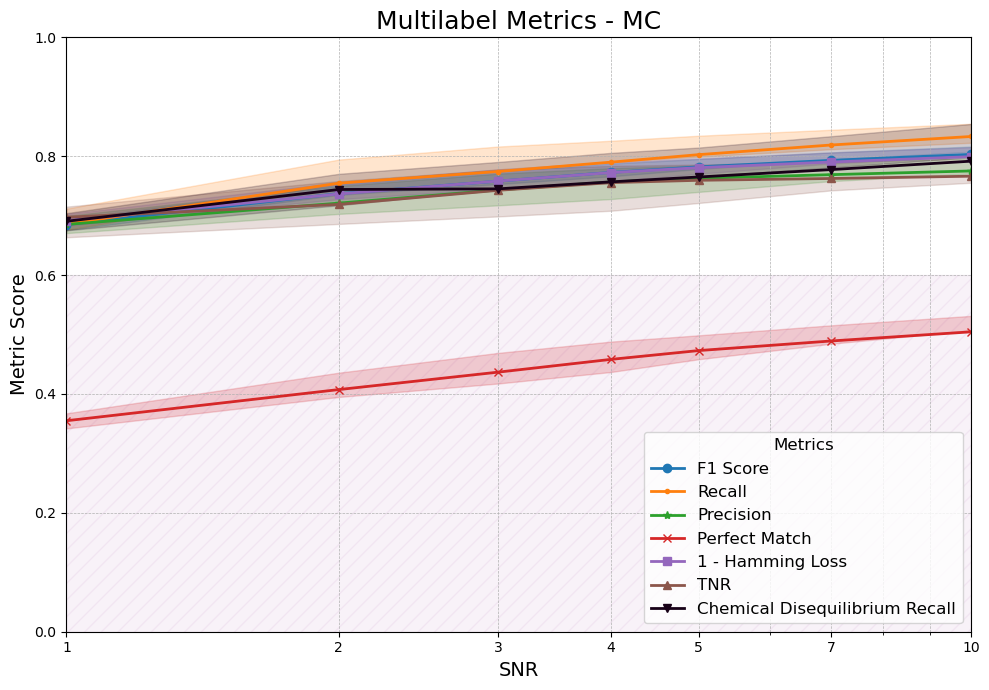

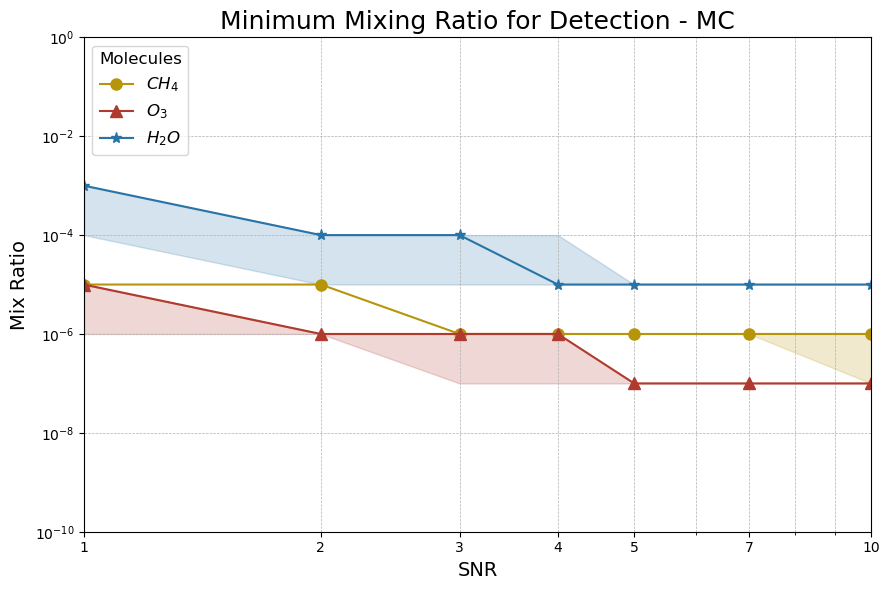

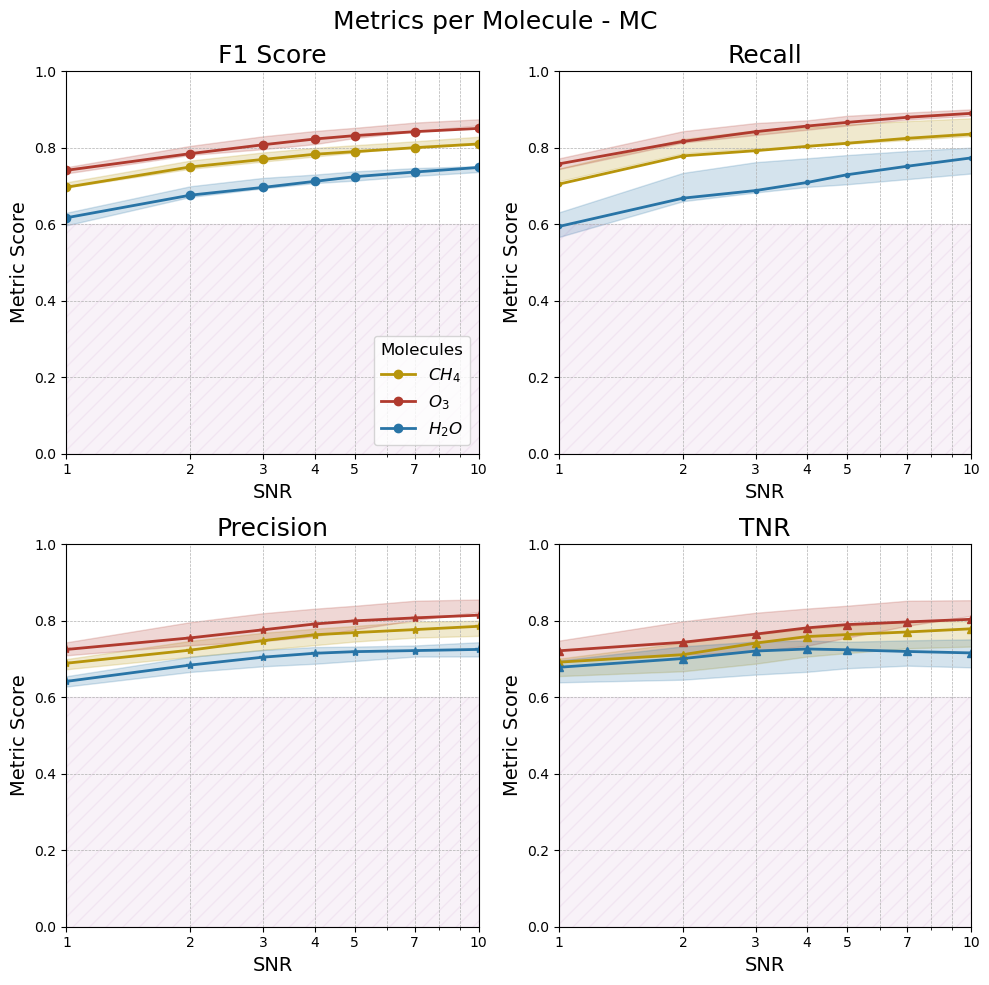

In [12]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from collections import OrderedDict


base_f_spot = 0
base_f_fac = 0
SNRS = [1, 2, 3, 4, 5, 7, 10]
mix_ratios = np.logspace(-8, -1, 8)

base_global_scores = all_results[(base_f_spot, base_f_fac)]["global_SNR_scores"]
base_mol_scores = all_results[(base_f_spot, base_f_fac)]["mol_SNR_scores"]


def adjust_color_lightness(color, amount=0.7):
    """Adjust the lightness of a given color."""
    try:
        c = mcolors.to_rgb(color)
    except ValueError:
        c = (0.5, 0.5, 0.5)
    return [min(1, max(0, channel * amount)) for channel in c]


base_global_scores["1_hamming_loss"] = 1 - np.array(base_global_scores["hamming_loss"])

global_metrics_colors = {
    "f1": "#1f77b4",
    "recall": "#ff7f0e",
    "precision": "#2ca02c",
    "perfect_match": "#d62728",
    "1_hamming_loss": "#9467bd",
    "TNR": "#8c564b",
    "biosignature_recall": "#180118",
}

global_metrics_markers = {
    "f1": "o",
    "recall": ".",
    "precision": "*",
    "perfect_match": "x",
    "1_hamming_loss": "s",
    "TNR": "^",
    "biosignature_recall": "v",
}

global_titles = {
    "f1": "F1 Score",
    "recall": "Recall",
    "precision": "Precision",
    "perfect_match": "Perfect Match",
    "1_hamming_loss": "1 - Hamming Loss",
    "TNR": "TNR",
    "biosignature_recall": "Biosignature Recall (CH4 & O3)",
}

global_metrics = [
    "f1",
    "recall",
    "precision",
    "perfect_match",
    "1_hamming_loss",
    "TNR",
    "biosignature_recall",
]

ch4_base_color = "#B7950B"
o3_base_color = "#B03A2E"
h2o_base_color = "#2874A6"
molecules_colors = [ch4_base_color, o3_base_color, h2o_base_color]
molecules_labels = ["$CH_4$", "$O_3$", "$H_2O$"]

mol_metrics_markers = {
    "f1": "o",
    "recall_score": ".",
    "precision_score": "*",
    "TNR": "^",
}

available_mol_keys = base_mol_scores.keys()
print("Available keys in mol_SNR_scores for the base case:", available_mol_keys)

if "recall_score" in available_mol_keys:
    metrics_keys_mol = ["f1", "recall_score", "precision_score", "TNR"]
    metrics_titles_mol = ["F1 Score", "Recall", "Precision", "TNR"]
elif "recall" in available_mol_keys:
    metrics_keys_mol = ["f1", "recall", "precision_score", "TNR"]
    metrics_titles_mol = ["F1 Score", "Recall", "Precision", "TNR"]
else:
    raise KeyError(
        "Neither 'recall_score' nor 'recall' are available in 'mol_SNR_scores'."
    )


def get_min_max_global(metric, snrs):
    """
    Calculate min and max for a global metric over all (f_spot, f_fac)
    combinations (excluding the base case).
    """
    mins, maxs = [], []
    for snr in snrs:
        values = []
        for (fsp, ffac), results in all_results.items():
            if fsp == base_f_spot and ffac == base_f_fac:
                continue
            if snr in results["global_SNR_scores"]["SNR"]:
                idx = results["global_SNR_scores"]["SNR"].index(snr)
                if metric == "1_hamming_loss":
                    val = 1 - results["global_SNR_scores"]["hamming_loss"][idx]
                else:
                    val = results["global_SNR_scores"][metric][idx]
                values.append(val)
        if values:
            mins.append(min(values))
            maxs.append(max(values))
        else:
            base_val = base_global_scores[metric][base_global_scores["SNR"].index(snr)]
            mins.append(base_val)
            maxs.append(base_val)
    return np.array(mins), np.array(maxs)


def get_min_max_mol(metric, mol_idx, snrs):
    """
    Calculate min and max for a molecule-specific metric over all (f_spot, f_fac)
    combinations.
    """
    mins, maxs = [], []
    for snr in snrs:
        values = []
        for (fsp, ffac), results in all_results.items():
            if fsp == base_f_spot and ffac == base_f_fac:
                continue
            if snr in results["mol_SNR_scores"]["SNR"]:
                idx = results["mol_SNR_scores"]["SNR"].index(snr)
                val = results["mol_SNR_scores"][metric][mol_idx][idx]
                values.append(val)
        if values:
            mins.append(min(values))
            maxs.append(max(values))
        else:
            base_val = base_mol_scores[metric][mol_idx][base_mol_scores["SNR"].index(snr)]
            mins.append(base_val)
            maxs.append(base_val)
    return np.array(mins), np.array(maxs)


plt.figure(figsize=(10, 7))
snrs = base_global_scores["SNR"]

for metric in global_metrics:
    min_vals, max_vals = get_min_max_global(metric, snrs)
    plt.fill_between(snrs, min_vals, max_vals,
                     color=global_metrics_colors[metric], alpha=0.2)
    base_y = (
        base_global_scores["1_hamming_loss"]
        if metric == "1_hamming_loss"
        else base_global_scores[metric]
    )
    plt.plot(snrs, base_y,
             marker=global_metrics_markers[metric],
             color=global_metrics_colors[metric],
             linewidth=2,
             label=("Chemical Disequilibrium Recall"
                    if metric == "biosignature_recall" else global_titles[metric]))

plt.fill_between(snrs, 0, 0.6, color="purple", alpha=0.05, hatch="//")
plt.xscale("log")
plt.xlabel("SNR", fontsize=14)
plt.ylabel("Metric Score", fontsize=14)
plt.xticks([1, 2, 3, 4, 5, 7, 10], [str(x) for x in [1, 2, 3, 4, 5, 7, 10]])
plt.xlim(1, 10)
plt.ylim(0, 1)
plt.title("Multilabel Metrics - MC", fontsize=18)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
ax.ticklabel_format(axis="x", style="plain")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),
           title="Metrics", title_fontsize=12,
           loc="lower right", fontsize=12)
plt.tight_layout()
#plt.savefig("fotos/auto-MC-mulmetrics.svg", dpi=300)
plt.show()

plt.figure(figsize=(9, 6))
plt.plot(SNRS, base_mol_scores["min_mix_ratio"][0], "-o",
         label="$CH_4$", color=ch4_base_color, markersize=8)
plt.plot(SNRS, base_mol_scores["min_mix_ratio"][1], "-^",
         label="$O_3$", color=o3_base_color, markersize=8)
plt.plot(SNRS, base_mol_scores["min_mix_ratio"][2], "-*",
         label="$H_2O$", color=h2o_base_color, markersize=8)
for mol_idx, _ in enumerate(molecules_labels):
    min_vals, max_vals = get_min_max_mol("min_mix_ratio", mol_idx, SNRS)
    plt.fill_between(SNRS, min_vals, max_vals,
                     color=molecules_colors[mol_idx], alpha=0.2)
plt.xscale("log")
plt.xlabel("SNR", fontsize=14)
plt.ylabel("Mix Ratio", fontsize=14)
plt.xticks([1, 2, 3, 4, 5, 7, 10],
           [str(x) for x in [1, 2, 3, 4, 5, 7, 10]])
plt.xlim(1, 10)
plt.yscale("log")
plt.ylim(1e-10, 1)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
ax.ticklabel_format(axis="x", style="plain")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),
           title="Molecules", title_fontsize=12,
           loc="upper left", fontsize=12)
plt.title("Minimum Mixing Ratio for Detection - MC", fontsize=18)
plt.tight_layout()
#plt.savefig("fotos/auto-MC-minmix.svg", dpi=300)
plt.show()

fig_mol, axs_mol = plt.subplots(2, 2, figsize=(10, 10))
axs_mol = axs_mol.flatten()
snrs = base_mol_scores["SNR"]

for i, (m_key, title) in enumerate(zip(metrics_keys_mol, metrics_titles_mol)):
    ax = axs_mol[i]
    for mol_idx, mol_label in enumerate(molecules_labels):
        min_vals, max_vals = get_min_max_mol(m_key, mol_idx, snrs)
        ax.fill_between(snrs, min_vals, max_vals,
                        color=molecules_colors[mol_idx], alpha=0.2)
        ax.plot(snrs, base_mol_scores[m_key][mol_idx],
                marker=mol_metrics_markers[m_key],
                color=molecules_colors[mol_idx],
                linewidth=2,
                label=mol_label)
    ax.fill_between(snrs, 0, 0.6, color="purple", alpha=0.05, hatch="//")
    ax.set_xscale("log")
    ax.set_xlabel("SNR", fontsize=14)
    ax.set_ylabel("Metric Score", fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.set_xticks(SNRS)
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    ax.set_xlim(1, 10)
    ax.set_ylim(0, 1)
    ax.ticklabel_format(axis="x", style="plain")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    if i == 0:
        ax.legend(loc="lower right", fontsize=12,
                  title="Molecules", title_fontsize=12)
fig_mol.suptitle("Metrics per Molecule - MC", fontsize=18)
fig_mol.tight_layout()
#plt.savefig("fotos/auto-MC-molmetrics.svg", dpi=300)
plt.show()


## Validate vs other molecules

SNR=3
18775/18775 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step


C:\Users\User\AppData\Local\Temp\ipykernel_28156\1297160212.py:311: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


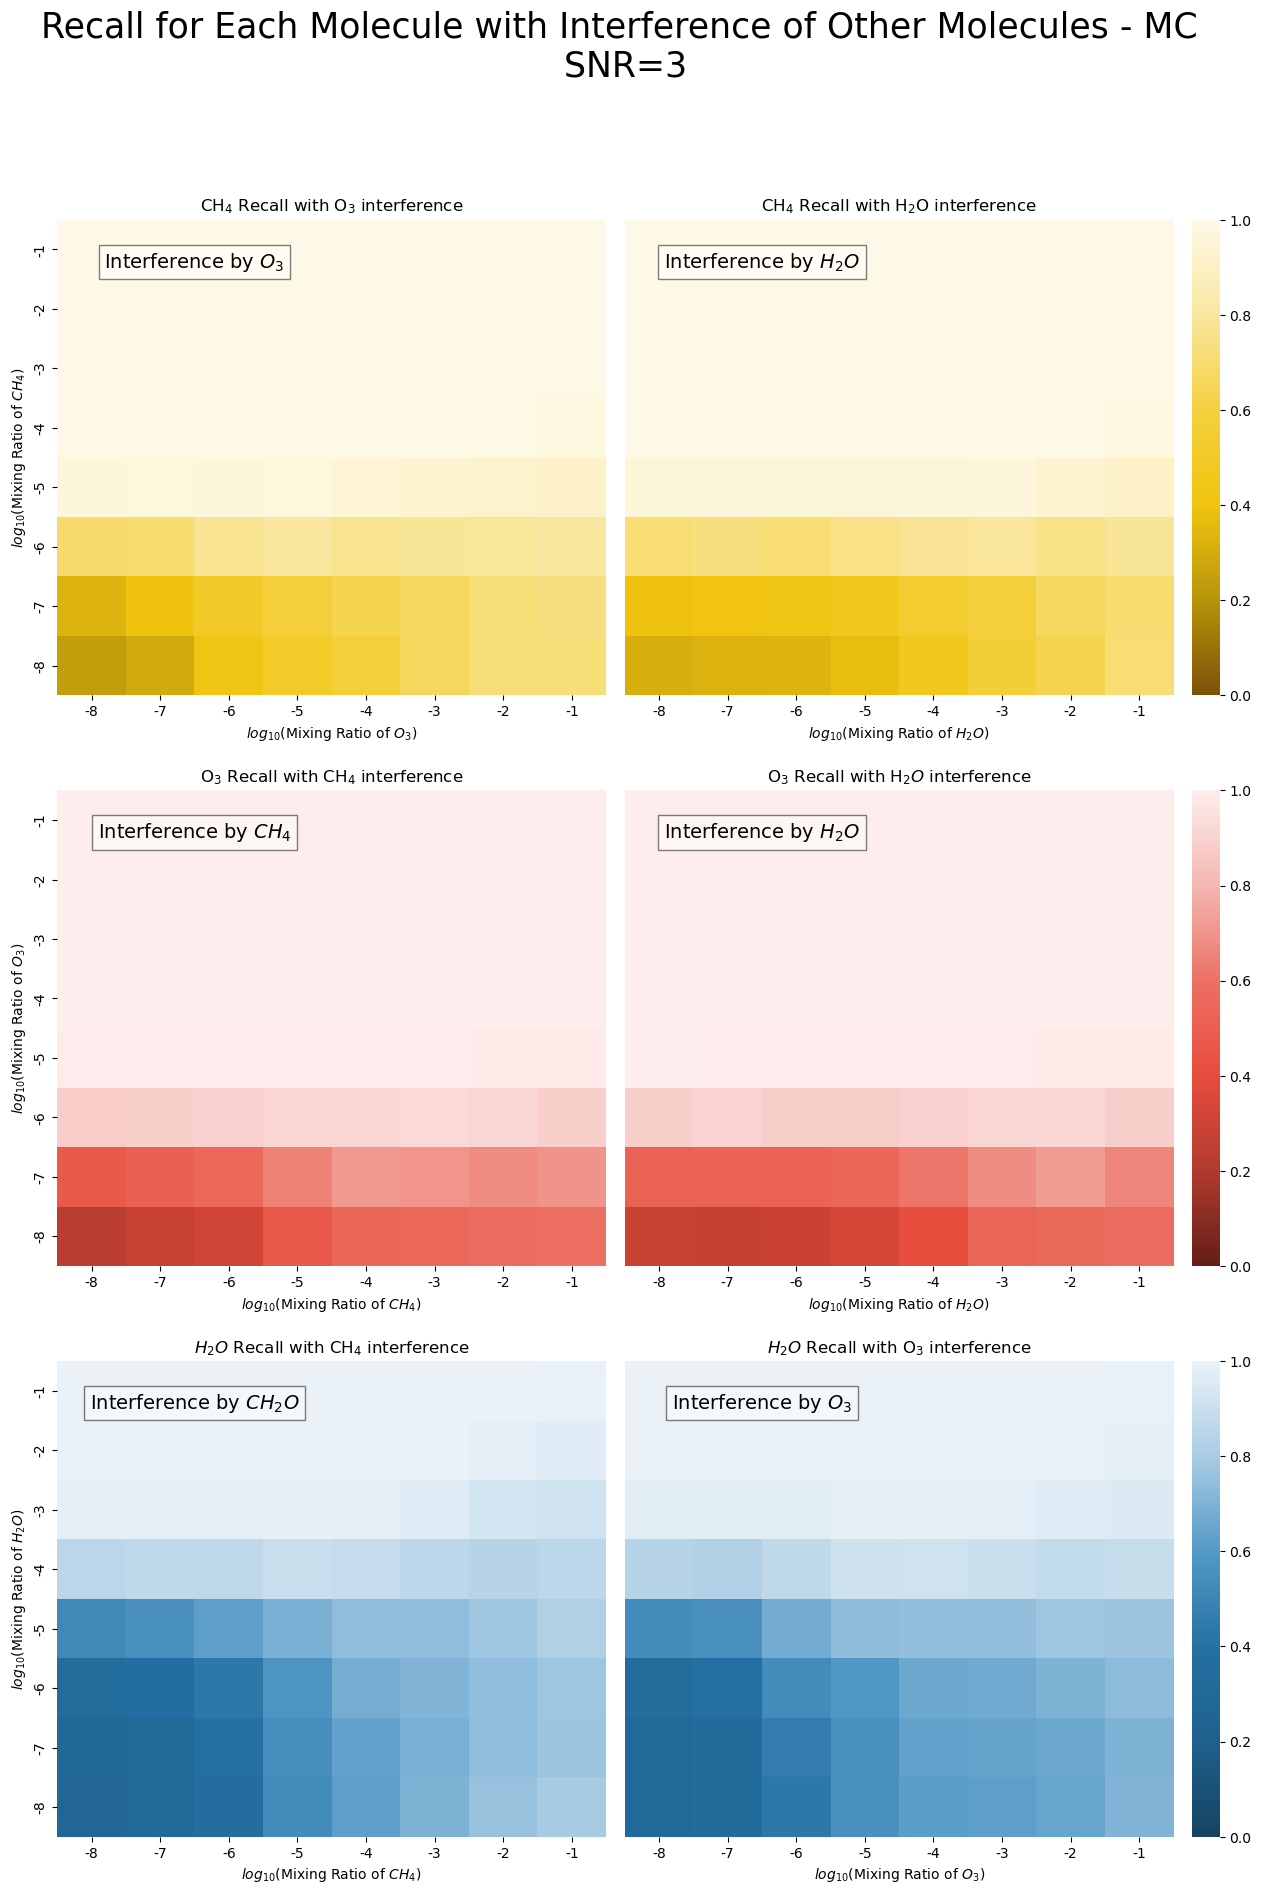

In [13]:
SNRS = [3]

for SNR in SNRS:
    print(f"SNR={SNR}")
    remove_warnings()   
    noise = mrex.generate_df_SNR_noise(
        df=CO2_data,
        n_repeat=1,
        SNR=SNR
    )["noise"][1]

    SNR_test_CO2_data = generate_df_with_noise_std(
        df=CO2_data,
        n_repeat=5000,
        noise_std=noise
    )
    SNR_test_CH4_data = generate_df_with_noise_std(
        df=CH4_data,
        n_repeat=250,
        noise_std=noise
    )
    SNR_test_O3_data = generate_df_with_noise_std(
        df=O3_data,
        n_repeat=250,
        noise_std=noise
    )
    SNR_test_H2O_data = generate_df_with_noise_std(
        df=H2O_data,
        n_repeat=250,
        noise_std=noise
    )
    SNR_test_CH4_O3_data = generate_df_with_noise_std(
        df=CH4_O3_data,
        n_repeat=25,
        noise_std=noise
    )
    SNR_test_CH4_H2O_data = generate_df_with_noise_std(
        df=CH4_H2O_data,
        n_repeat=25,
        noise_std=noise
    )
    SNR_test_O3_H2O_data = generate_df_with_noise_std(
        df=O3_H2O_data,
        n_repeat=25,
        noise_std=noise
    )
    SNR_test_CH4_O3_H2O_data = generate_df_with_noise_std(
        df=CH4_O3_H2O_data,
        n_repeat=5,
        noise_std=noise
    )
    SNR_test_noatm_data = generate_df_with_noise_std(
        df=airless_data,
        n_repeat=5000,
        noise_std=noise
    )

    SNR_test_df = pd.concat(
        [
            SNR_test_CO2_data,
            SNR_test_CH4_data,
            SNR_test_O3_data,
            SNR_test_H2O_data,
            SNR_test_CH4_O3_data,
            SNR_test_CH4_H2O_data,
            SNR_test_O3_H2O_data,
            SNR_test_CH4_O3_H2O_data,
            SNR_test_noatm_data,
        ],
        ignore_index=True,
    )

    del (
        SNR_test_CO2_data,
        SNR_test_CH4_data,
        SNR_test_O3_data,
        SNR_test_H2O_data,
        SNR_test_CH4_O3_data,
        SNR_test_CH4_H2O_data,
        SNR_test_O3_H2O_data,
        SNR_test_CH4_O3_H2O_data,
        SNR_test_noatm_data,
    )
    gc.collect()

    SNR_test_df["label"] = SNR_test_df["label"].apply(string_to_list)
    SNR_test_df.iloc[:, -n_points:] = normalize_min_max_by_row(
        SNR_test_df.iloc[:, -n_points:]
    )
    SNR_X_test = encoder.predict(SNR_test_df.iloc[:, -n_points:])

    SNR_test_CH4 = np.array([item[0] for item in SNR_test_df["label"]])
    SNR_test_O3 = np.array([item[1] for item in SNR_test_df["label"]])
    SNR_test_H2O = np.array([item[2] for item in SNR_test_df["label"]])

    SNR_test_df["CH4 label"] = SNR_test_CH4
    SNR_test_df["O3 label"] = SNR_test_O3
    SNR_test_df["H2O label"] = SNR_test_H2O

    # Move the last three columns to the beginning
    cols = list(SNR_test_df.columns)
    SNR_test_df = SNR_test_df[cols[-3:] + cols[:-3]]

    CH4_probabilities = rf.predict_proba(SNR_X_test)[0][:, 1]
    O3_probabilities = rf.predict_proba(SNR_X_test)[1][:, 1]
    H2O_probabilities = rf.predict_proba(SNR_X_test)[2][:, 1]

    CH4_threshold = 0.28
    O3_threshold = 0.24
    H2O_threshold = 0.36

    CH4_y_pred = (CH4_probabilities > CH4_threshold).astype(int)
    O3_y_pred = (O3_probabilities > O3_threshold).astype(int)
    H2O_y_pred = (H2O_probabilities > H2O_threshold).astype(int)

    SNR_test_df["CH4 pred"] = CH4_y_pred
    SNR_test_df["O3 pred"] = O3_y_pred
    SNR_test_df["H2O pred"] = H2O_y_pred

    # Initialize matrices for accuracy scores
    si_CH4_sO3 = np.zeros((8, 8))
    si_CH4_sH2O = np.zeros((8, 8))
    si_O3_sCH4 = np.zeros((8, 8))
    si_O3_sH2O = np.zeros((8, 8))
    si_H2O_sCH4 = np.zeros((8, 8))
    si_H2O_sO3 = np.zeros((8, 8))

    for i, mix1 in enumerate(range(-8, 0)):
        for j, mix2 in enumerate(range(-8, 0)):
            permix_si_CH4_sO3 = SNR_test_df[
                (SNR_test_df["atm O3"] == mix2)
                & (SNR_test_df["atm CH4"] == mix1)
            ]
            permix_si_CH4_sH2O = SNR_test_df[
                (SNR_test_df["atm H2O"] == mix2)
                & (SNR_test_df["atm CH4"] == mix1)
            ]
            permix_si_O3_sCH4 = SNR_test_df[
                (SNR_test_df["atm CH4"] == mix2)
                & (SNR_test_df["atm O3"] == mix1)
            ]
            permix_si_O3_sH2O = SNR_test_df[
                (SNR_test_df["atm H2O"] == mix2)
                & (SNR_test_df["atm O3"] == mix1)
            ]
            permix_si_H2O_sCH4 = SNR_test_df[
                (SNR_test_df["atm CH4"] == mix2)
                & (SNR_test_df["atm H2O"] == mix1)
            ]
            permix_si_H2O_sO3 = SNR_test_df[
                (SNR_test_df["atm O3"] == mix2)
                & (SNR_test_df["atm H2O"] == mix1)
            ]
            si_CH4_sO3[i, j] = accuracy_score(
                permix_si_CH4_sO3["CH4 label"], permix_si_CH4_sO3["CH4 pred"]
            )
            si_CH4_sH2O[i, j] = accuracy_score(
                permix_si_CH4_sH2O["CH4 label"], permix_si_CH4_sH2O["CH4 pred"]
            )
            si_O3_sCH4[i, j] = accuracy_score(
                permix_si_O3_sCH4["O3 label"], permix_si_O3_sCH4["O3 pred"]
            )
            si_O3_sH2O[i, j] = accuracy_score(
                permix_si_O3_sH2O["O3 label"], permix_si_O3_sH2O["O3 pred"]
            )
            si_H2O_sCH4[i, j] = accuracy_score(
                permix_si_H2O_sCH4["H2O label"], permix_si_H2O_sCH4["H2O pred"]
            )
            si_H2O_sO3[i, j] = accuracy_score(
                permix_si_H2O_sO3["H2O label"], permix_si_H2O_sO3["H2O pred"]
            )

    log_ratios = np.arange(-8, 0, 1)

    # Define custom colormaps
    from matplotlib.colors import LinearSegmentedColormap

    color_scales = {
        "CH4": ["#7E5109", "#B7950B", "#F1C40F", "#F4D03F", "#F9E79F", "#FEF9E7"],
        "O3": ["#641E16", "#B03A2E", "#E74C3C", "#EC7063", "#F5B7B1", "#FDEDEC"],
        "H2O": ["#154360", "#1F618D", "#2471A3", "#5499C7", "#A9CCE3", "#EAF2F8"],
    }
    color_ch4 = LinearSegmentedColormap.from_list("CH4", color_scales["CH4"], N=256)
    color_o3 = LinearSegmentedColormap.from_list("O3", color_scales["O3"], N=256)
    color_h2o = LinearSegmentedColormap.from_list("H2O", color_scales["H2O"], N=256)

    fig = plt.figure(figsize=(15, 21))
    gs = fig.add_gridspec(3, 3, width_ratios=[1, 1, 0.05], wspace=0.05)

    def add_label(ax, text):
        ax.annotate(
            text,
            xy=(0.25, 0.9),
            xycoords="axes fraction",
            fontsize=14,
            ha="center",
            bbox=dict(facecolor="white", alpha=0.5),
        )

    ax1 = fig.add_subplot(gs[0, 0])
    sns.heatmap(
        si_CH4_sO3,
        ax=ax1,
        vmin=0,
        vmax=1,
        xticklabels=log_ratios,
        yticklabels=log_ratios,
        cmap=color_ch4,
        cbar=False,
    )
    ax1.set_title("CH$_4$ Recall with O$_3$ interference")
    ax1.set_xlabel("$log_{10}$(Mixing Ratio of $O_3$)")
    ax1.set_ylabel("$log_{10}$(Mixing Ratio of $CH_4$)")
    ax1.invert_yaxis()
    add_label(ax1, "Interference by $O_3$")

    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    cbar_ax1 = fig.add_subplot(gs[0, 2])
    sns.heatmap(
        si_CH4_sH2O,
        ax=ax2,
        vmin=0,
        vmax=1,
        xticklabels=log_ratios,
        yticklabels=log_ratios,
        cmap=color_ch4,
        cbar_ax=cbar_ax1,
    )
    ax2.set_title("CH$_4$ Recall with H$_2$O interference")
    ax2.set_xlabel("$log_{10}$(Mixing Ratio of $H_2O$)")
    ax2.yaxis.set_visible(False)
    ax2.invert_yaxis()
    add_label(ax2, "Interference by $H_2O$")

    ax3 = fig.add_subplot(gs[1, 0])
    sns.heatmap(
        si_O3_sCH4,
        ax=ax3,
        vmin=0,
        vmax=1,
        xticklabels=log_ratios,
        yticklabels=log_ratios,
        cmap=color_o3,
        cbar=False,
    )
    ax3.set_title("O$_3$ Recall with CH$_4$ interference")
    ax3.set_xlabel("$log_{10}$(Mixing Ratio of $CH_4$)")
    ax3.set_ylabel("$log_{10}$(Mixing Ratio of $O_3$)")
    ax3.invert_yaxis()
    add_label(ax3, "Interference by $CH_4$")

    ax4 = fig.add_subplot(gs[1, 1], sharey=ax3)
    cbar_ax2 = fig.add_subplot(gs[1, 2])
    sns.heatmap(
        si_O3_sH2O,
        ax=ax4,
        vmin=0,
        vmax=1,
        xticklabels=log_ratios,
        yticklabels=log_ratios,
        cmap=color_o3,
        cbar_ax=cbar_ax2,
    )
    ax4.set_title("O$_3$ Recall with H$_2O$ interference")
    ax4.set_xlabel("$log_{10}$(Mixing Ratio of $H_2O$)")
    ax4.set_ylabel("$log_{10}$(Mixing Ratio of $O_3$)")
    ax4.invert_yaxis()
    ax4.yaxis.set_visible(False)
    add_label(ax4, "Interference by $H_2O$")

    ax5 = fig.add_subplot(gs[2, 0])
    sns.heatmap(
        si_H2O_sCH4,
        ax=ax5,
        vmin=0,
        vmax=1,
        xticklabels=log_ratios,
        yticklabels=log_ratios,
        cmap=color_h2o,
        cbar=False,
    )
    ax5.set_title("$H_2O$ Recall with CH$_4$ interference")
    ax5.set_xlabel("$log_{10}$(Mixing Ratio of $CH_4$)")
    ax5.set_ylabel("$log_{10}$(Mixing Ratio of $H_2O$)")
    ax5.invert_yaxis()
    add_label(ax5, "Interference by $CH_2O$")
    
    ax6 = fig.add_subplot(gs[2, 1], sharey=ax5)
    cbar_ax3 = fig.add_subplot(gs[2, 2])
    sns.heatmap(
        si_H2O_sO3,
        ax=ax6,
        vmin=0,
        vmax=1,
        xticklabels=log_ratios,
        yticklabels=log_ratios,
        cmap=color_h2o,
        cbar_ax=cbar_ax3,
    )
    ax6.set_title("$H_2O$ Recall with O$_3$ interference")
    ax6.set_xlabel("$log_{10}$(Mixing Ratio of $O_3$)")
    ax6.set_ylabel("$log_{10}$(Mixing Ratio of $H_2O$)")
    ax6.invert_yaxis()
    ax6.yaxis.set_visible(False)
    add_label(ax6, "Interference by $O_3$")

    plt.suptitle(
        f"Recall for Each Molecule with Interference of Other Molecules - MC\n SNR={SNR}",
        fontsize=25,
    )
    plt.tight_layout()
    plt.show()

SNR=1
24610/24610 ━━━━━━━━━━━━━━━━━━━━ 114s 5ms/step


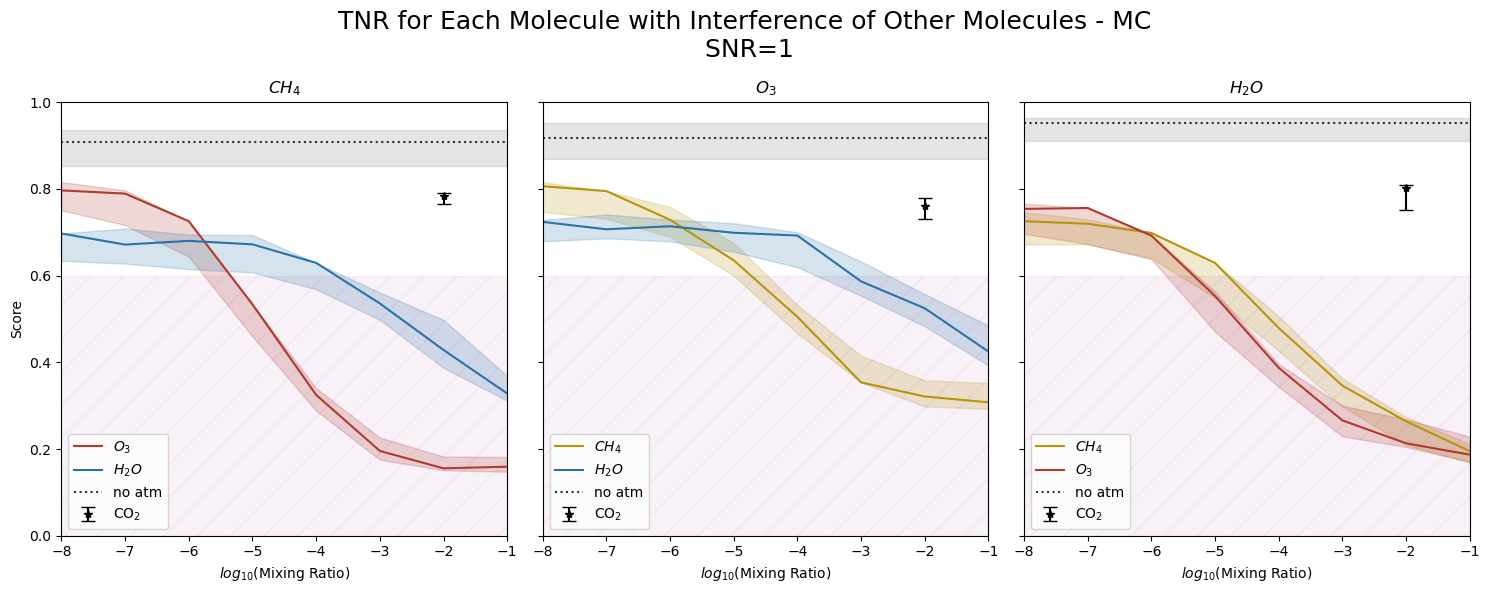

SNR=3
24610/24610 ━━━━━━━━━━━━━━━━━━━━ 123s 5ms/step


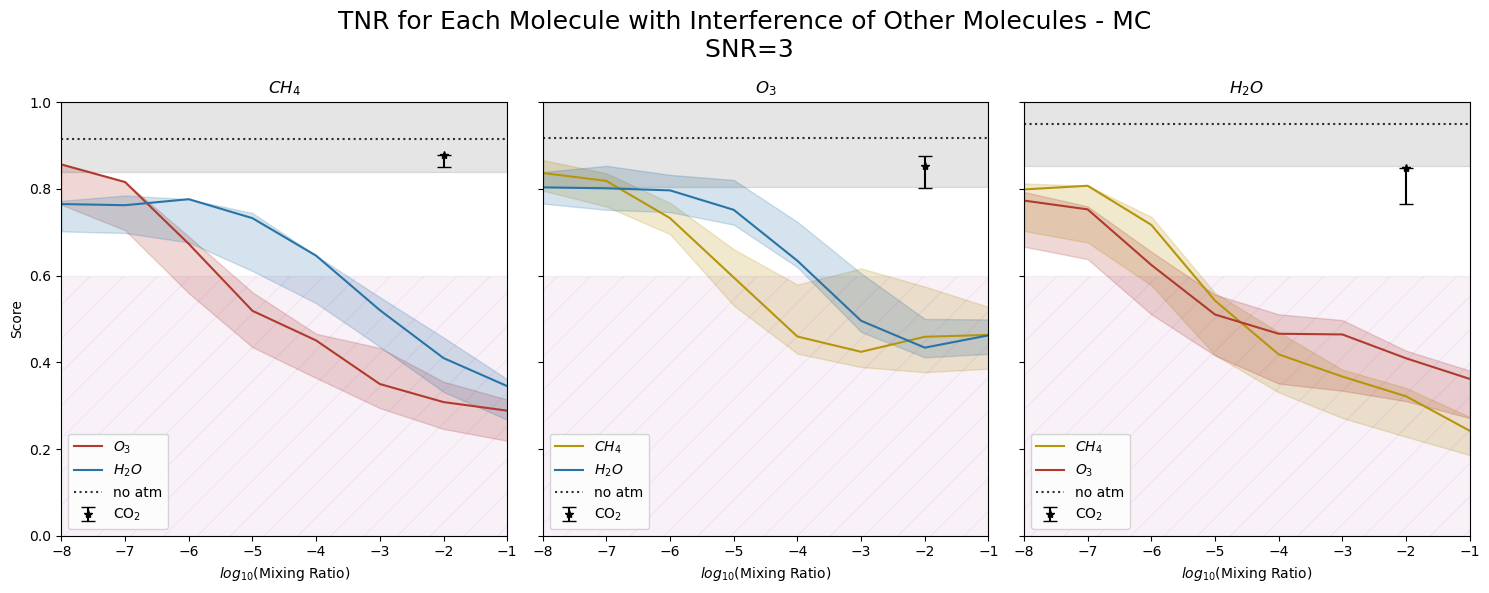

SNR=5
24610/24610 ━━━━━━━━━━━━━━━━━━━━ 122s 5ms/step


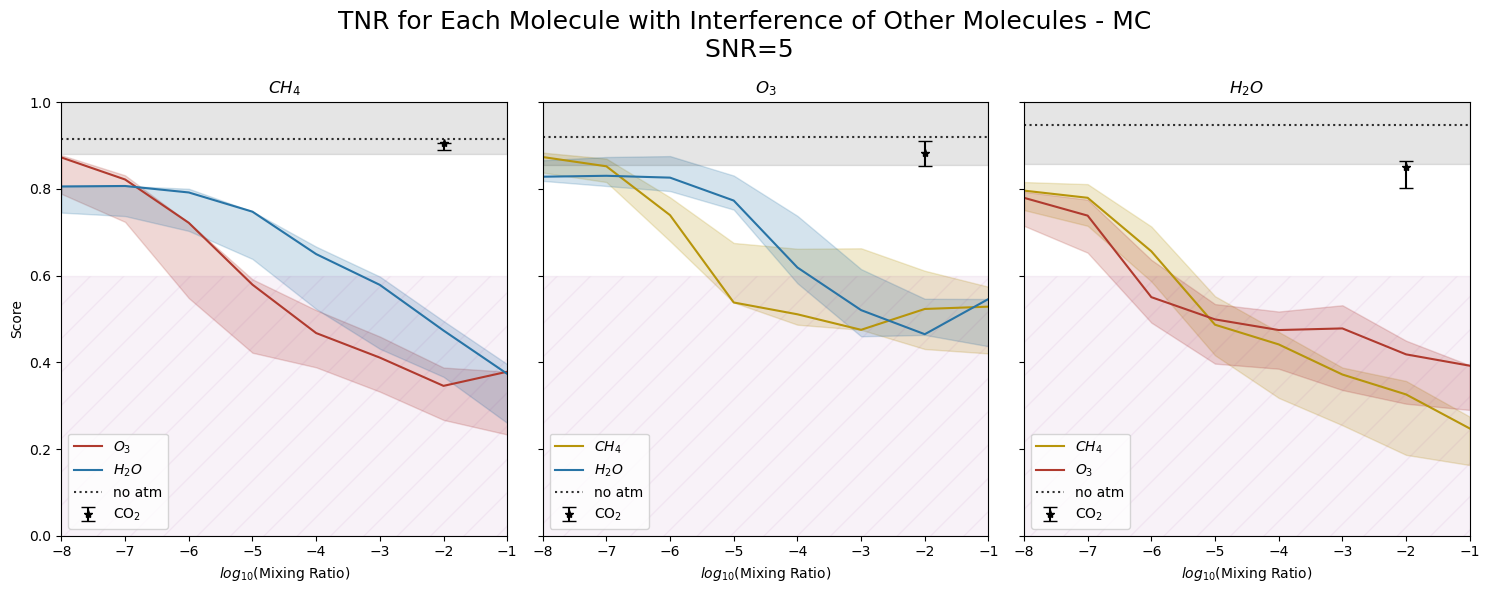

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import gc
from sklearn.metrics import accuracy_score

# Define SNR values and contamination parameters
SNRS = [1, 3, 5]
factor = 10 / 8
f_spot_values = [0, 0.01, 0.08, 0.26]
f_fac_values = [0, 0.08, 0.54, 0.70]

for SNR in SNRS:
    print(f"SNR={SNR}")
    remove_warnings()
    noise = mrex.generate_df_SNR_noise(
        df=CO2_data,
        n_repeat=1,
        SNR=SNR,
    )["noise"][1]

    SNR_test_CO2_data = generate_df_with_noise_std(
        df=CO2_data,
        n_repeat=5000,
        noise_std=noise,
    )
    SNR_test_CH4_data = generate_df_with_noise_std(
        df=CH4_data,
        n_repeat=int(250 * factor),
        noise_std=noise,
    )
    SNR_test_O3_data = generate_df_with_noise_std(
        df=O3_data,
        n_repeat=int(250 * factor),
        noise_std=noise,
    )
    SNR_test_H2O_data = generate_df_with_noise_std(
        df=H2O_data,
        n_repeat=int(250 * factor),
        noise_std=noise,
    )
    SNR_test_CH4_O3_data = generate_df_with_noise_std(
        df=CH4_O3_data,
        n_repeat=int(25 * factor * factor),
        noise_std=noise,
    )
    SNR_test_CH4_H2O_data = generate_df_with_noise_std(
        df=CH4_H2O_data,
        n_repeat=int(25 * factor * factor),
        noise_std=noise,
    )
    SNR_test_O3_H2O_data = generate_df_with_noise_std(
        df=O3_H2O_data,
        n_repeat=int(25 * factor * factor),
        noise_std=noise,
    )
    SNR_test_CH4_O3_H2O_data = generate_df_with_noise_std(
        df=CH4_O3_H2O_data,
        n_repeat=int(5 * factor * factor * factor),
        noise_std=noise,
    )
    SNR_test_noatm_data = generate_df_with_noise_std(
        df=airless_data,
        n_repeat=5000,
        noise_std=noise,
    )

    SNR_test_df = pd.concat(
        [
            SNR_test_CO2_data,
            SNR_test_CH4_data,
            SNR_test_O3_data,
            SNR_test_H2O_data,
            SNR_test_CH4_O3_data,
            SNR_test_CH4_H2O_data,
            SNR_test_O3_H2O_data,
            SNR_test_CH4_O3_H2O_data,
            SNR_test_noatm_data,
        ],
        ignore_index=True,
    )

    del (
        SNR_test_CO2_data,
        SNR_test_CH4_data,
        SNR_test_O3_data,
        SNR_test_H2O_data,
        SNR_test_CH4_O3_data,
        SNR_test_CH4_H2O_data,
        SNR_test_O3_H2O_data,
        SNR_test_CH4_O3_H2O_data,
        SNR_test_noatm_data,
    )
    gc.collect()

    # Preprocess the DataFrame
    SNR_test_df["label"] = SNR_test_df["label"].apply(string_to_list)
    SNR_test_df.iloc[:, -n_points:] = normalize_min_max_by_row(
        SNR_test_df.iloc[:, -n_points:]
    )
    SNR_X_test = encoder.predict(SNR_test_df.iloc[:, -n_points:])

    SNR_test_CH4 = np.array([item[0] for item in SNR_test_df["label"]])
    SNR_test_O3 = np.array([item[1] for item in SNR_test_df["label"]])
    SNR_test_H2O = np.array([item[2] for item in SNR_test_df["label"]])

    SNR_test_df["CH4 label"] = SNR_test_CH4
    SNR_test_df["O3 label"] = SNR_test_O3
    SNR_test_df["H2O label"] = SNR_test_H2O

    # Move the last three columns to the beginning
    cols = list(SNR_test_df.columns)
    SNR_test_df = SNR_test_df[cols[-3:] + cols[:-3]]

    # Make predictions
    CH4_probabilities = rf.predict_proba(SNR_X_test)[0][:, 1]
    O3_probabilities = rf.predict_proba(SNR_X_test)[1][:, 1]
    H2O_probabilities = rf.predict_proba(SNR_X_test)[2][:, 1]

    CH4_threshold = 0.28
    O3_threshold = 0.24
    H2O_threshold = 0.36

    CH4_y_pred = (CH4_probabilities > CH4_threshold).astype(int)
    O3_y_pred = (O3_probabilities > O3_threshold).astype(int)
    H2O_y_pred = (H2O_probabilities > H2O_threshold).astype(int)

    SNR_test_df["CH4 pred"] = CH4_y_pred
    SNR_test_df["O3 pred"] = O3_y_pred
    SNR_test_df["H2O pred"] = H2O_y_pred

    # Define mixing ratio range and initialize arrays to store accuracy scores
    mix_ratios = np.array(range(-8, 0))
    all_no_CH4_sO3 = []
    all_no_CH4_sH2O = []
    all_no_O3_sCH4 = []
    all_no_O3_sH2O = []
    all_no_H2O_sCH4 = []
    all_no_H2O_sO3 = []
    all_no_CH4_sCO2 = []
    all_no_O3_sCO2 = []
    all_no_H2O_sCO2 = []
    all_no_CH4_noatm = []
    all_no_O3_noatm = []
    all_no_H2O_noatm = []

    def filtrar_data(df, f_spot_val, f_fac_val):
        return df[(df["f_spot"] == f_spot_val) & (df["f_fac"] == f_fac_val)]

    for f_spot_val in f_spot_values:
        for f_fac_val in f_fac_values:
            df_cont = filtrar_data(SNR_test_df, f_spot_val, f_fac_val)
            if df_cont.empty:
                continue

            tmp_no_CH4_sO3 = np.zeros(len(mix_ratios))
            tmp_no_CH4_sH2O = np.zeros(len(mix_ratios))
            tmp_no_O3_sCH4 = np.zeros(len(mix_ratios))
            tmp_no_O3_sH2O = np.zeros(len(mix_ratios))
            tmp_no_H2O_sCH4 = np.zeros(len(mix_ratios))
            tmp_no_H2O_sO3 = np.zeros(len(mix_ratios))

            for i, mix in enumerate(mix_ratios):
                permix_no_CH4_sO3 = df_cont[(df_cont["atm O3"] == mix) &
                                             (df_cont["atm CH4"] == 0)]
                permix_no_CH4_sH2O = df_cont[(df_cont["atm H2O"] == mix) &
                                             (df_cont["atm CH4"] == 0)]
                permix_no_O3_sCH4 = df_cont[(df_cont["atm CH4"] == mix) &
                                            (df_cont["atm O3"] == 0)]
                permix_no_O3_sH2O = df_cont[(df_cont["atm H2O"] == mix) &
                                            (df_cont["atm O3"] == 0)]
                permix_no_H2O_sCH4 = df_cont[(df_cont["atm CH4"] == mix) &
                                             (df_cont["atm H2O"] == 0)]
                permix_no_H2O_sO3 = df_cont[(df_cont["atm O3"] == mix) &
                                            (df_cont["atm H2O"] == 0)]

                tmp_no_CH4_sO3[i] = (
                    accuracy_score(permix_no_CH4_sO3["CH4 label"],
                                   permix_no_CH4_sO3["CH4 pred"])
                    if len(permix_no_CH4_sO3) > 0
                    else np.nan
                )
                tmp_no_CH4_sH2O[i] = (
                    accuracy_score(permix_no_CH4_sH2O["CH4 label"],
                                   permix_no_CH4_sH2O["CH4 pred"])
                    if len(permix_no_CH4_sH2O) > 0
                    else np.nan
                )
                tmp_no_O3_sCH4[i] = (
                    accuracy_score(permix_no_O3_sCH4["O3 label"],
                                   permix_no_O3_sCH4["O3 pred"])
                    if len(permix_no_O3_sCH4) > 0
                    else np.nan
                )
                tmp_no_O3_sH2O[i] = (
                    accuracy_score(permix_no_O3_sH2O["O3 label"],
                                   permix_no_O3_sH2O["O3 pred"])
                    if len(permix_no_O3_sH2O) > 0
                    else np.nan
                )
                tmp_no_H2O_sCH4[i] = (
                    accuracy_score(permix_no_H2O_sCH4["H2O label"],
                                   permix_no_H2O_sCH4["H2O pred"])
                    if len(permix_no_H2O_sCH4) > 0
                    else np.nan
                )
                tmp_no_H2O_sO3[i] = (
                    accuracy_score(permix_no_H2O_sO3["H2O label"],
                                   permix_no_H2O_sO3["H2O pred"])
                    if len(permix_no_H2O_sO3) > 0
                    else np.nan
                )

            # CO2 and airless cases (single values)
            val_no_mol_sCO2 = df_cont[
                (df_cont["atm O3"] == 0)
                & (df_cont["atm H2O"] == 0)
                & (df_cont["atm CO2"] == -2)
            ]
            no_CH4_sCO2 = (
                accuracy_score(val_no_mol_sCO2["CH4 label"], val_no_mol_sCO2["CH4 pred"])
                if len(val_no_mol_sCO2) > 0
                else np.nan
            )
            no_O3_sCO2 = (
                accuracy_score(val_no_mol_sCO2["O3 label"], val_no_mol_sCO2["O3 pred"])
                if len(val_no_mol_sCO2) > 0
                else np.nan
            )
            no_H2O_sCO2 = (
                accuracy_score(val_no_mol_sCO2["H2O label"], val_no_mol_sCO2["H2O pred"])
                if len(val_no_mol_sCO2) > 0
                else np.nan
            )

            val_noatm = df_cont[df_cont["atm CO2"] == 0]
            no_CH4_noatm = (
                accuracy_score(val_noatm["CH4 label"], val_noatm["CH4 pred"])
                if len(val_noatm) > 0
                else np.nan
            )
            no_O3_noatm = (
                accuracy_score(val_noatm["O3 label"], val_noatm["O3 pred"])
                if len(val_noatm) > 0
                else np.nan
            )
            no_H2O_noatm = (
                accuracy_score(val_noatm["H2O label"], val_noatm["H2O pred"])
                if len(val_noatm) > 0
                else np.nan
            )

            all_no_CH4_sO3.append(tmp_no_CH4_sO3)
            all_no_CH4_sH2O.append(tmp_no_CH4_sH2O)
            all_no_O3_sCH4.append(tmp_no_O3_sCH4)
            all_no_O3_sH2O.append(tmp_no_O3_sH2O)
            all_no_H2O_sCH4.append(tmp_no_H2O_sCH4)
            all_no_H2O_sO3.append(tmp_no_H2O_sO3)
            all_no_CH4_sCO2.append(no_CH4_sCO2)
            all_no_O3_sCO2.append(no_O3_sCO2)
            all_no_H2O_sCO2.append(no_H2O_sCO2)
            all_no_CH4_noatm.append(no_CH4_noatm)
            all_no_O3_noatm.append(no_O3_noatm)
            all_no_H2O_noatm.append(no_H2O_noatm)

    all_no_CH4_sO3 = np.array(all_no_CH4_sO3)
    all_no_CH4_sH2O = np.array(all_no_CH4_sH2O)
    all_no_O3_sCH4 = np.array(all_no_O3_sCH4)
    all_no_O3_sH2O = np.array(all_no_O3_sH2O)
    all_no_H2O_sCH4 = np.array(all_no_H2O_sCH4)
    all_no_H2O_sO3 = np.array(all_no_H2O_sO3)
    all_no_CH4_sCO2 = np.array(all_no_CH4_sCO2)
    all_no_O3_sCO2 = np.array(all_no_O3_sCO2)
    all_no_H2O_sCO2 = np.array(all_no_H2O_sCO2)
    all_no_CH4_noatm = np.array(all_no_CH4_noatm)
    all_no_O3_noatm = np.array(all_no_O3_noatm)
    all_no_H2O_noatm = np.array(all_no_H2O_noatm)

    def min_max_array(arr):
        if arr.size == 0:
            return (np.full(len(mix_ratios), np.nan), np.full(len(mix_ratios), np.nan))
        return (np.nanmin(arr, axis=0), np.nanmax(arr, axis=0))

    def single_min_max(arr):
        return (
            np.nanmin(arr) if arr.size > 0 else np.nan,
            np.nanmax(arr) if arr.size > 0 else np.nan,
        )

    no_CH4_sO3_min, no_CH4_sO3_max = min_max_array(all_no_CH4_sO3)
    no_CH4_sH2O_min, no_CH4_sH2O_max = min_max_array(all_no_CH4_sH2O)
    no_O3_sCH4_min, no_O3_sCH4_max = min_max_array(all_no_O3_sCH4)
    no_O3_sH2O_min, no_O3_sH2O_max = min_max_array(all_no_O3_sH2O)
    no_H2O_sCH4_min, no_H2O_sCH4_max = min_max_array(all_no_H2O_sCH4)
    no_H2O_sO3_min, no_H2O_sO3_max = min_max_array(all_no_H2O_sO3)
    no_CH4_sCO2_min, no_CH4_sCO2_max = single_min_max(all_no_CH4_sCO2)
    no_O3_sCO2_min, no_O3_sCO2_max = single_min_max(all_no_O3_sCO2)
    no_H2O_sCO2_min, no_H2O_sCO2_max = single_min_max(all_no_H2O_sCO2)
    no_CH4_noatm_min, no_CH4_noatm_max = single_min_max(all_no_CH4_noatm)
    no_O3_noatm_min, no_O3_noatm_max = single_min_max(all_no_O3_noatm)
    no_H2O_noatm_min, no_H2O_noatm_max = single_min_max(all_no_H2O_noatm)

    # Calculate the base curve (f_spot=0, f_fac=0)
    base_df = filtrar_data(SNR_test_df, 0, 0)
    base_no_CH4_sO3 = np.zeros(len(mix_ratios))
    base_no_CH4_sH2O = np.zeros(len(mix_ratios))
    base_no_O3_sCH4 = np.zeros(len(mix_ratios))
    base_no_O3_sH2O = np.zeros(len(mix_ratios))
    base_no_H2O_sCH4 = np.zeros(len(mix_ratios))
    base_no_H2O_sO3 = np.zeros(len(mix_ratios))

    for i, mix in enumerate(mix_ratios):
        permix_no_CH4_sO3 = base_df[(base_df["atm O3"] == mix) & (base_df["atm CH4"] == 0)]
        permix_no_CH4_sH2O = base_df[(base_df["atm H2O"] == mix) & (base_df["atm CH4"] == 0)]
        permix_no_O3_sCH4 = base_df[(base_df["atm CH4"] == mix) & (base_df["atm O3"] == 0)]
        permix_no_O3_sH2O = base_df[(base_df["atm H2O"] == mix) & (base_df["atm O3"] == 0)]
        permix_no_H2O_sCH4 = base_df[(base_df["atm CH4"] == mix) & (base_df["atm H2O"] == 0)]
        permix_no_H2O_sO3 = base_df[(base_df["atm O3"] == mix) & (base_df["atm H2O"] == 0)]

        base_no_CH4_sO3[i] = (
            accuracy_score(permix_no_CH4_sO3["CH4 label"], permix_no_CH4_sO3["CH4 pred"])
            if len(permix_no_CH4_sO3) > 0
            else np.nan
        )
        base_no_CH4_sH2O[i] = (
            accuracy_score(permix_no_CH4_sH2O["CH4 label"], permix_no_CH4_sH2O["CH4 pred"])
            if len(permix_no_CH4_sH2O) > 0
            else np.nan
        )
        base_no_O3_sCH4[i] = (
            accuracy_score(permix_no_O3_sCH4["O3 label"], permix_no_O3_sCH4["O3 pred"])
            if len(permix_no_O3_sCH4) > 0
            else np.nan
        )
        base_no_O3_sH2O[i] = (
            accuracy_score(permix_no_O3_sH2O["O3 label"], permix_no_O3_sH2O["O3 pred"])
            if len(permix_no_O3_sH2O) > 0
            else np.nan
        )
        base_no_H2O_sCH4[i] = (
            accuracy_score(permix_no_H2O_sCH4["H2O label"], permix_no_H2O_sCH4["H2O pred"])
            if len(permix_no_H2O_sCH4) > 0
            else np.nan
        )
        base_no_H2O_sO3[i] = (
            accuracy_score(permix_no_H2O_sO3["H2O label"], permix_no_H2O_sO3["H2O pred"])
            if len(permix_no_H2O_sO3) > 0
            else np.nan
        )

    val_no_mol_sCO2_base = base_df[
        (base_df["atm O3"] == 0) & (base_df["atm H2O"] == 0) & (base_df["atm CO2"] == -2)
    ]
    base_no_CH4_sCO2 = (
        accuracy_score(val_no_mol_sCO2_base["CH4 label"], val_no_mol_sCO2_base["CH4 pred"])
        if len(val_no_mol_sCO2_base) > 0
        else np.nan
    )
    base_no_O3_sCO2 = (
        accuracy_score(val_no_mol_sCO2_base["O3 label"], val_no_mol_sCO2_base["O3 pred"])
        if len(val_no_mol_sCO2_base) > 0
        else np.nan
    )
    base_no_H2O_sCO2 = (
        accuracy_score(val_no_mol_sCO2_base["H2O label"], val_no_mol_sCO2_base["H2O pred"])
        if len(val_no_mol_sCO2_base) > 0
        else np.nan
    )

    val_noatm_base = base_df[base_df["atm CO2"] == 0]
    base_no_CH4_noatm = (
        accuracy_score(val_noatm_base["CH4 label"], val_noatm_base["CH4 pred"])
        if len(val_noatm_base) > 0
        else np.nan
    )
    base_no_O3_noatm = (
        accuracy_score(val_noatm_base["O3 label"], val_noatm_base["O3 pred"])
        if len(val_noatm_base) > 0
        else np.nan
    )
    base_no_H2O_noatm = (
        accuracy_score(val_noatm_base["H2O label"], val_noatm_base["H2O pred"])
        if len(val_noatm_base) > 0
        else np.nan
    )

    # Plot results for CH4, O3, and H2O
    fig, ax = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

    # CH4 plot: fill bands and plot base curves
    ax[0].fill_between(mix_ratios, no_CH4_sO3_min, no_CH4_sO3_max,
                       color="#B03A2E", alpha=0.2)
    ax[0].plot(mix_ratios, base_no_CH4_sO3, label="$O_3$", color="#B03A2E")
    ax[0].fill_between(mix_ratios, no_CH4_sH2O_min, no_CH4_sH2O_max,
                       color="#2874A6", alpha=0.2)
    ax[0].plot(mix_ratios, base_no_CH4_sH2O, label="$H_2O$", color="#2874A6")
    if not np.isnan(base_no_CH4_sCO2):
        ax[0].errorbar(-2, base_no_CH4_sCO2,
                       yerr=[[base_no_CH4_sCO2 - no_CH4_sCO2_min],
                             [no_CH4_sCO2_max - base_no_CH4_sCO2]],
                       fmt="*", color="k", capsize=5, label="CO$_2$")
    if not np.isnan(base_no_CH4_noatm):
        ax[0].axhline(base_no_CH4_noatm, color="k", ls=":", alpha=0.8, label="no atm")
        if not np.isnan(no_CH4_noatm_min) and not np.isnan(no_CH4_noatm_max):
            ax[0].fill_between(mix_ratios, no_CH4_noatm_min, no_CH4_noatm_max,
                               color="k", alpha=0.1)
    ax[0].set_title("$CH_4$")
    ax[0].fill_between([-9, 1], 0, 0.6, hatch="/", color="purple", alpha=0.05)
    ax[0].set_xlabel("$log_{10}$(Mixing Ratio)")
    ax[0].set_ylabel("Score")
    ax[0].set_xlim(-8, -1)
    ax[0].set_ylim(0, 1)
    ax[0].legend()

    # O3 plot
    ax[1].fill_between(mix_ratios, no_O3_sCH4_min, no_O3_sCH4_max,
                       color="#B7950B", alpha=0.2)
    ax[1].plot(mix_ratios, base_no_O3_sCH4, label="$CH_4$", color="#B7950B")
    ax[1].fill_between(mix_ratios, no_O3_sH2O_min, no_O3_sH2O_max,
                       color="#2874A6", alpha=0.2)
    ax[1].plot(mix_ratios, base_no_O3_sH2O, label="$H_2O$", color="#2874A6")
    if not np.isnan(base_no_O3_sCO2):
        ax[1].errorbar(-2, base_no_O3_sCO2,
                       yerr=[[base_no_O3_sCO2 - no_O3_sCO2_min],
                             [no_O3_sCO2_max - base_no_O3_sCO2]],
                       fmt="*", color="k", capsize=5, label="CO$_2$")
    if not np.isnan(base_no_O3_noatm):
        ax[1].axhline(base_no_O3_noatm, color="k", ls=":", alpha=0.8, label="no atm")
        if not np.isnan(no_O3_noatm_min) and not np.isnan(no_O3_noatm_max):
            ax[1].fill_between(mix_ratios, no_O3_noatm_min, no_O3_noatm_max,
                               color="k", alpha=0.1)
    ax[1].set_title("$O_3$")
    ax[1].fill_between([-9, 1], 0, 0.6, hatch="/", color="purple", alpha=0.05)
    ax[1].set_xlabel("$log_{10}$(Mixing Ratio)")
    ax[1].set_xlim(-8, -1)
    ax[1].set_ylim(0, 1)
    ax[1].legend()

    # H2O plot
    ax[2].fill_between(mix_ratios, no_H2O_sCH4_min, no_H2O_sCH4_max,
                       color="#B7950B", alpha=0.2)
    ax[2].plot(mix_ratios, base_no_H2O_sCH4, label="$CH_4$", color="#B7950B")
    ax[2].fill_between(mix_ratios, no_H2O_sO3_min, no_H2O_sO3_max,
                       color="#B03A2E", alpha=0.2)
    ax[2].plot(mix_ratios, base_no_H2O_sO3, label="$O_3$", color="#B03A2E")
    if not np.isnan(base_no_H2O_sCO2):
        ax[2].errorbar(-2, base_no_H2O_sCO2,
                       yerr=[[base_no_H2O_sCO2 - no_H2O_sCO2_min],
                             [no_H2O_sCO2_max - base_no_H2O_sCO2]],
                       fmt="*", color="k", capsize=5, label="CO$_2$")
    if not np.isnan(base_no_H2O_noatm):
        ax[2].axhline(base_no_H2O_noatm, color="k", ls=":", alpha=0.8, label="no atm")
        if not np.isnan(no_H2O_noatm_min) and not np.isnan(no_H2O_noatm_max):
            ax[2].fill_between(mix_ratios, no_H2O_noatm_min, no_H2O_noatm_max,
                               color="k", alpha=0.1)
    ax[2].set_title("$H_2O$")
    ax[2].fill_between([-9, 1], 0, 0.6, hatch="/", color="purple", alpha=0.05)
    ax[2].set_xlabel("$log_{10}$(Mixing Ratio)")
    ax[2].set_xlim(-8, -1)
    ax[2].set_ylim(0, 1)
    ax[2].legend()

    plt.suptitle(
        f"TNR for Each Molecule with Interference of Other Molecules - MC\n SNR={SNR}",
        fontsize=18,
    )
    plt.tight_layout()
    plt.show()
